# Baseline Computer Vision methods for Planetary-scale training for National or Regional PV Solar Panel surveys

*CCOM6120: Computer Vision*  
**Alejandro Vega Nogales**  
*Data Scientist @ Maxar Puerto Rico*   
*CCOM MS Student*

In [1]:
if 'google.colab' in str(get_ipython()):
    import os
    import random
    import shutil
    print('Running on CoLab')
    from google.colab import drive
    from google.colab import userdata
    import secrets

    drive.mount('/content/drive', force_remount=True)
    # create dirs to mirror local file tree
    os.makedirs('/content/datasets/raw/labels', exist_ok=True)
    os.makedirs('/content/datasets/raw/images', exist_ok=True)

    # copy over report folder for figures and other assets, and utils scripts
    os.makedirs('/content/report', exist_ok=True)
    if not os.path.exists('/content/report/assets'):
        shutil.copytree('/content/drive/MyDrive/CCOM_MS_Training_Datasets_Logs/report/assets', '/content/report/assets')
    if not os.path.exists('/content/utils'):
        shutil.copytree('/content/drive/MyDrive/CCOM_MS_Training_Datasets_Logs/utils', '/content/utils')
    if not os.path.exists('./.env'):
        shutil.copy('/content/drive/MyDrive/CCOM_MS_Training_Datasets_Logs/.env', './.env')

    !ls -a

In [2]:
colab_train_requirements = [
    'rasterio' # we'll be sourcing from several tiff datasets
    , '"segmentation_models_pytorch>=0.5"' # for all our segmentation models; need ver >= 0.5 for ViT models
    , 'ultralytics' # for potential YOLO finetuning
    , '"lightning>=2.5.1"'
    , 'seedir' # package for creating, editing, and reading folder tree diagrams; not used here but imported in utils
    , 'datahugger' # same as above
    , 'dotenv'
    , 'coremltools'
    , 'cubo',
    'rioxarray'
    ,'pystac_client'
    , 'albumentations'
]

!pip install {' '.join(colab_train_requirements)}

In [3]:
# %% --- 1. Setup & Imports ---
# Standard libraries
import os
import time
from pathlib import Path
import warnings
import json
import shutil
import traceback
import random
from glob import glob

# Geospatial libraries
import geopandas as gpd
import rasterio
from rasterio.transform import Affine # For geotransforms
import cubo
import rioxarray # cubo often returns DataArrays that need rioxarray for CRS handling
import pystac_client # For STAC API interaction with cubo
from shapely import wkt
from shapely.geometry import Point # For pv_gdf demo

# ML/DL libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
# from torchvision.transforms.v2 import Compose, RandomApply, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, RandomRotation, RandomResizedCrop, RandomAffine, ToTensor, Normalize
import albumentations as A
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, SoftBCEWithLogitsLoss
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryJaccardIndex, BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from lightning.pytorch import Trainer

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, IFrame

from utils.fetch_and_preprocess import (
    yolo_labels_to_binary_mask,
    process_yolo_label_directory
)
from utils.torch_datasets import PVSegmentationDataset, PVSegmentationDataModule

from dotenv import load_dotenv

# --- Suppress specific warnings ---
warnings.filterwarnings("ignore", category=UserWarning, module="rasterio")
warnings.filterwarnings("ignore", message=".* Shapely GEOS version .*")
# Suppress the NotGeoreferencedWarning specifically
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

## Research Problem & Motivation

### Importance of monitoring and tracking Renewable Energy Installations

As the world transitions to renewable energy sources, solar photovoltaic (PV) installations are growing exponentially worldwide. Accurate mapping and monitoring of these installations  
is crucial for energy planning, grid management, carbon accounting, and sustainable development. However, traditional methods of tracking PV installations rely on incomplete permit data,  
manual surveys, or voluntary reporting—all of which present significant gaps in coverage and accuracy.

### Global Significance

Accurate mapping of solar PV installations has far-reaching implications:

- **Energy transition monitoring**:     Tracking actual deployment rates of solar PV against climate targets
- **Grid integration**:
    - Precise location of distributed energy resources for power system planning
    - Short-term forecasting of PV power generated (via solar flux estimates) for countries with high PV integration in their grid is essential for maintaining grid stability
- **Environmental impact assessment**:
    - Understanding land use changes and habitat effects of renewable energy development
- **Socioeconomic analysis**:
    - Studying adoption patterns across different communities to inform equitable energy transition policies
- **Sustainable Development Goals**:
   - Contributing to efforts that can directly address the UN's SDG 7 (Affordable and Clean Energy) and SDG 13 (Climate Action)

### The role of Remote Sensing and Computer Vision

Remote sensing and computer vision techniques can provide a scalable and efficient solution to monitor and map solar PV installations. By leveraging high-resolution satellite imagery, we can automate the detection and classification of solar panels, enabling large-scale assessments of solar energy deployment.

...

### The Challenge of PV Segmentation

Satellite imagery offers a promising solution for automated detection of PV installations at regional and global scales. Yet, several challenges make this a non-trivial computer vision problem:

1. **Multi-scale challenge**: PV installations vary dramatically in size, from small residential rooftop panels (a few m²) to utility-scale solar farms (several km²)
2. **Visual variability**: PV panels appear differently depending on panel type, orientation, age, viewing angle, and illumination conditions
3. **Resolution trade-offs**: As demonstrated in Clark et al.'s study (2023), detection performance is strongly affected by image resolution, creating a compromise between coverage area and detection accuracy
4. **Class imbalance**: PV installations typically occupy a small fraction of any given geographic area, creating extreme class imbalance in training data
5. **Data scarcity**: High-quality labeled datasets for training are limited and geographically biased toward certain regions

<figure style="text-align: center">
<img src="report/assets/figures/Munich_2021-06-18_WV03_HD_16x9.jpg" style="width:70%; height:auto;">
<figcaption align = "center"> 31cm native resolution vs simulated "15.5"cm spatial resolution from our dataset</figcaption>
</figure>

In [4]:

# html in markdown doesn't seem to render in colab; display images for presentation via iPython
img = widgets.Image(value=open("report/assets/figures/Munich_2021-06-18_WV03_HD_16x9.jpg", "rb").read(), format='jpg', width='95%', height='auto')
display(img)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x02\…

### Related Work and Background

In their seminal work with very high resolution (VHR) satellite imagery *(< 1 meter/pixel*), Cecilia Clark and Fabio Pacifici (2023) demonstrated that resolution significantly impacts detection performance, with our employer's (Maxar Intelligence) ["HD Technology" product](https://blog.maxar.com/tech-and-tradecraft/2022/maxars-hd-technology-provides-measurable-improvements-in-machine-learning-applications) (proprietary upscaling algorithm capable of simulating 15.5cm GSD) delivering substantially better results than native resolution (31cm) imagery. This **resolution-performance trade-off** informs our approach to developing models that can work effectively across varying image resolutions. They summarize the challenges succinctly below:

- **"Residential solar panels are considered small, weak targets even in VHR satellite imagery due to the average number of pixels per object, variation among objects, and complex context"**.
- *Existing satellite imagery datasets often include large-scale, or non-residential, solar panel annotations* due to resolution of the imagery and therefore inability to detect small objects.
- There are available datasets of VHR imagery to support accurate detection
of small-scale and residential installations, but **the imagery is generally sourced from aerial platforms.** and are limited to local city contexts

By establishing baseline segmentation techniques in preparation for more advanced models, this research contributes to the broader goal of creating comprehensive, accurate, and timely inventories of global PV installations—a critical capability for managing the ongoing energy transition.

<!-- <figure style="text-align: center">
<img src="https://github.com/avega17/CCOM_MS_Spring_2025_EO_PV_research/blob/main/report/assets/figures/maxar_hd_vs_native_comparison.jpg?raw=1" style="width:70%; height:auto;">
</figure>
<figure style="text-align: center">
<img src="https://github.com/avega17/CCOM_MS_Spring_2025_EO_PV_research/blob/main/report/assets/figures/maxar_hd_vs_native_comparison2.jpg?raw=1" style="width:70%; height:auto;">
<figcaption align = "center"> 31cm native resolution vs simulated "15.5"cm spatial resolution from our dataset</figcaption> -->
<!-- </figure> -->

In [5]:
# simulate 2x1 div like below
img1 = widgets.Image(value=open("report/assets/figures/maxar_hd_vs_native_comparison.jpg", "rb").read(), format='jpg', width='90%', height='auto')
img2 = widgets.Image(value=open("report/assets/figures/maxar_hd_vs_native_comparison2.jpg", "rb").read(), format='jpg', width='90%', height='auto')
imgs_rows = widgets.VBox([img1, img2])
# add caption

display(imgs_rows)

### Research Questions

This project aims to address the following key questions:

1. How can we leverage *SOTA DL architectures* to improve PV segmentation accuracy across diverse geographic regions including **regions with sparse data**?

2. Can *PyTorch's Lightning framework* enable more **efficient experimentation across multiple model architectures** to efficiently identify optimal approaches for this domain-specific problem?

3. What **combination of data augmentation strategies, model architectures, loss functions, and training approaches** best addresses the unique challenges of PV segmentation?

4. How can we optimize models to work effectively across **different spatial resolutions** while maximizing the area that can be covered in operational settings?

<!-- <figure style="text-align: center">
<div style="display: flex; flex-direction: row; gap: 20px; width: 100%;">
    <div style="flex: 1; text-align: center;">
        <img src="report/assets/figures/Planet_MS_global_renewables_watch_lo_res_comparison.png" style="width: 100%; height: auto;">
        <p>Imagery available in Global Renewables Watch atlas</p>
    </div>
    <div style="flex: 1; text-align: center;">
        <img src="report/assets/figures/maxar_mgp_renewables_planet_comparison.png" style="width: 100%; height: auto;">
        <p> Blue + RedEdge + NIR composite from Maxar Geospatial Platform </p>
    </div>
</div>
<figcaption align = "center">  PV imagery: PlanetLabs Dove vs Maxar Worldview-3  </figcaption>
</figure> -->


<!-- <div style="display: flex; flex-direction: row; gap: 20px; width: 100%;">
    <div style="flex: 1; text-align: center;">
        <img src="report/assets/figures/unetplusplus_architecture.png" style="width: 100%; height: auto;">
        <p>UNet++ Architecture</p>
    </div>
    <div style="flex: 1; text-align: center;">
        <img src="report/assets/figures/deeplabv3plus_architecture.png" style="width: 100%; height: auto;">
        <p>DeepLabV3+ Architecture</p>
    </div>
</div> -->

In [6]:
# simulate 1x2 div layout like above
img1 = widgets.Image(value=open('report/assets/figures/Planet_MS_global_renewables_watch_lo_res_comparison.png', "rb").read(), format='png', width='50%', height='auto')
img2 = widgets.Image(value=open('report/assets/figures/maxar_mgp_renewables_planet_comparison.png', "rb").read(), format='png', width='50%', height='auto')
imgs_cols = widgets.HBox([img1, img2], layout=widgets.Layout(justify_content='center'))
# add html caption
fig_caption = widgets.HTML('<p>PV imagery: PlanetLabs Dove vs Maxar Worldview-3</p>')
figure = widgets.VBox([imgs_cols, fig_caption])
# see Box layout manipulation docs: https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Layout.html#the-flexbox-layout
figure.layout.display = 'flex'
figure.layout.flex_flow = 'column'
figure.layout.align_items = 'center'
figure.layout.width = '100%'
display(figure)

# PV Segmentation with Torch Lightning & SMP

This notebook provides a framework for training and evaluating deep learning models for solar photovoltaic (PV) panel segmentation from satellite imagery. It leverages the power and flexibility of PyTorch Lightning for streamlined training and `segmentation-models-pytorch` (SMP) for easy access to a wide variety of cutting-edge model architectures.

This notebook will demonstrate the benefits of using PyTorch Lightning for organizing code and simplifying complex training workflows, and leveraging `segmentation-models-pytorch` (SMP) allows for rapid experimentation with different model backbones and architectures.

**Key Goals for this Notebook:**
1.  **Data Preparation:** Set up a PyTorch Lightning DataModule to efficiently load and preprocess image patches and their corresponding masks derived from the datasets listed above (or similar).
2.  **Model Definition:** Define a reusable PyTorch LightningModule that can accommodate various segmentation architectures from `segmentation-models-pytorch`.
3.  **Training:** Execute training loops, leveraging PyTorch Lightning's features for hardware acceleration (including Apple Silicon MPS), logging, and checkpointing.
4.  **Evaluation:** Assess model performance using relevant metrics and visualize predictions.
5.  **Logging with Weights & Biases:** Track experiments and log metrics using Weights & Biases.

**Assumptions for this Notebook:**
*   Image patches and their corresponding binary masks are assumed to be pre-prepared (e.g., using the `fetch-pv-datasets-ESDA.ipynb` notebook or similar methods) and stored in specified directories.
*   The notebook is designed to be adaptable for different datasets, such as those derived from Maxar imagery with YOLO labels converted to masks, or other datasets providing pixel-coordinate labels that have been rasterized to masks.


In [7]:
# display gpu runtime to inform model and encoder choice
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    !nvidia-smi

In [8]:
# Load environment variables from .env file
load_dotenv()
print(os.environ.items())

gdrive_prefix = '/content/drive/MyDrive/CCOM_MS_Training_Datasets_Logs'
dataset_paths = {
    'Maxar Germany VHR MSI': {
        'chips': ('gdrive', 'datasets/raw/images/maxar_hd_south_germany_PV_OD.zip'),
        'labels': ('gdrive', 'datasets/raw/labels/maxar_hd_south_germany_PV_OD.zip')
    },
    'France crowdsourced aerials, rooftop': {
        'chips': ('zenodo', 'tmp'),
        'labels': ('gdrive', 'datasets/raw/labels/fra_west_eur_pv_installations_2023')
    },
    'USA Cali, USGS ortho aerials': {
        'chips': ('figshare', 'datasets/raw/images/usa_cali_usgs_pv_2016'),
        'labels': ('gdrive', 'datasets/raw/labels/usa_cali_usgs_pv_2016')
    }
}

N_SAMPLES_TO_VISUALIZE_DEMO = 2
S2_CHIP_SIZE_DEMO = 256
S2_RESOLUTION_DEMO = 10
S2_COLLECTION_DEMO = "sentinel-2-l2a" # STAC Collection to query

TIME_WINDOWS_DEMO = [
    ("2022-03-01/2022-03-31", "Mar 2022 (Spring)"),
    ("2022-07-01/2022-07-31", "Jul 2022 (Summer)"),
    ("2022-10-01/2022-10-31", "Oct 2022 (Fall)")
]

ItemsView(environ({'BW_SESSION': 'q7Az8tqWM27mgoo8zVqv+IX7xeNaYDqaTBcLSnA7OSlEWZcSMtmljNlzQIDeBI+z5AFYpR0r7prxixSNsXvupg==', 'COMMAND_MODE': 'unix2003', 'CONDA_DEFAULT_ENV': 'eo-pv-cv', 'CONDA_EXE': '/Users/alejandovega/miniforge3/bin/conda', 'CONDA_PREFIX': '/Users/alejandovega/miniforge3/envs/eo-pv-cv', 'CONDA_PROMPT_MODIFIER': '(eo-pv-cv) ', 'CONDA_PYTHON_EXE': '/Users/alejandovega/miniforge3/bin/python', 'CONDA_SHLVL': '2', 'HOME': '/Users/alejandovega', 'HOMEBREW_CELLAR': '/opt/homebrew/Cellar', 'HOMEBREW_PREFIX': '/opt/homebrew', 'HOMEBREW_REPOSITORY': '/opt/homebrew', 'INFOPATH': '/opt/homebrew/share/info', 'LC_CTYPE': 'en_US.UTF-8', 'LOGNAME': 'alejandovega', 'LaunchInstanceID': '26CAFB1D-AAF1-464A-B79A-5CDF4E2C5B4B', 'MallocNanoZone': '0', 'ORIGINAL_XDG_CURRENT_DESKTOP': 'undefined', 'PATH': '/Users/alejandovega/miniforge3/envs/eo-pv-cv/bin:/Users/alejandovega/miniforge3/condabin:/Applications/Visual Studio Code - Insiders.app/Contents/Resources/app/bin:/opt/homebrew/bin:/opt/

In [9]:
# %% --- 1.5 Dataset resolution and model+encoder selection ---

# User lighter combos locally and larger for colab
default_arch = "Linknet"
default_encoder = "resnet18"
# assign defaults for local training on Macbook MPS
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    # if using MPS
    default_arch = "UnetPlusPlus"
    default_encoder = "resnet50" # 25M
    print(f"Using MPS GPU with default arch {default_arch} and encoder {default_encoder}")
# use larger models and encoder based on available accelerator
if 'google.colab' in str(get_ipython()):
    # if using cuda gpu
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        if gpu_name == 'NVIDIA A100-SXM4-40GB':
            default_arch = 'Segformer'
            default_encoder = 'mit_b5' # 81M
        elif gpu_name == 'NVIDIA L4':
            default_arch = "UnetPlusPlus"
            default_encoder = "resnet152" #
        elif gpu_name == 'Tesla T4':
            default_arch = 'Linknet'
            default_encoder = 'mobilenet_v2'
        print(f"{gpu_name} has default arch {default_arch} and encoder {default_encoder}")
# Create radio buttons for selecting model architecture
model_arch_radio = widgets.RadioButtons(
    options=[
        'Unet', 'UnetPlusPlus',
        'FPN', 'Linknet', 'PSPNet',
        'DeepLabV3Plus', 'MAnet', 'PAN',
        'Segformer', 'DPT'
    ],
    value=default_arch,
    description='Select model arch:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

# Create radio buttons for selecting encoder
encoder_radio = widgets.Dropdown(
    options=['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
             'resnext50_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d', 'resnext101_32x48d',
             'senet154', 'se_resnet50', 'se_resnet101',
             'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d',
             'mobilenet_v2',
             'inceptionresnetv2',
             'efficientnet-b1', 'efficientnet-b3', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7',
             'timm-tf_efficientnet_lite4',
             'vgg16', 'vgg19', 'vgg16_bn',
             'densenet121', 'densenet169', 'densenet201', 'densenet161',
            # ViT encoders compatible with DPT
             'tu-fastvit_sa36.apple_dist_in1k',
             'tu-efficientformer_l3.snap_dist_in1k',
            #  mit
             'mit_b0', 'mit_b1', 'mit_b2', 'mit_b3', 'mit_b4', 'mit_b5',
            # swin
             'tu-swin_base_patch4_window7_224.ms_in22k_ft_in1k',
             'tu-swin_large_patch4_window7_224.ms_in22k_ft_in1k',
             'tu-swinv2_large_window12to16_192to256.ms_in22k_ft_in1k',
            # mobile
             'mobileone_s0', 'mobileone_s2', 'mobileone_s3', 'mobileone_s5',
             'tu-vitamin_large2_224.datacomp1b_clip',
             'tu-vit_medium_patch16_clip_224.tinyclip_yfcc15m',
             'tu-xcit_large_24_p8_384.fb_dist_in1k',
             'tu-twins_svt_base.in1k',
             ],
    value=default_encoder,
    description='Select encoder (backend):',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)


# Prioritizing lighter versions for initial testing
# MODEL_CONFIGURATIONS = {
#     "UnetPlusPlus_ResNet18": {"arch": "UnetPlusPlus", "encoder": "resnet18"},
#     "DeepLabV3Plus_MobileNetV2": {"arch": "DeepLabV3Plus", "encoder": "mobilenet_v2"},
#     "FPN_EfficientNetB0": {"arch": "FPN", "encoder": "efficientnet-b0"},
#     "MAnet_ResNet18": {"arch": "MAnet", "encoder": "resnet18"},
#     # DPT and Segformer are generally heavier, can be uncommented later
#     # "Segformer_MiTB0": {"arch": "Segformer", "encoder": "mit_b0"},
#     # "DPT_Hybrid_Tiny": {"arch": "DPT", "encoder": "vit_tiny_patch16_224"} # Check SMP for exact ViT encoder names for DPT
# }

# gemini cloud recommendations:
# "UnetPlusPlus_ResNet50": {"arch": "UnetPlusPlus", "encoder": "resnet50"},
#     "DeepLabV3Plus_EfficientNetB5": {"arch": "DeepLabV3Plus", "encoder": "efficientnet-b5"},
#     "FPN_ConvNeXt_Small": {"arch": "FPN", "encoder": "convnext_small"},
#     "DPT_ViTBase": {"arch": "DPT", "encoder": "vit_base_patch16_224"}, # Or larger ViT variant
#     "Segformer_MiTB3": {"arch": "Segformer", "encoder": "mit_b3"}, # Or mit_b4, mit_b5

MODEL_CONFIGURATIONS = {f"{model_arch_radio.value}_{encoder_radio.value}": {"arch": model_arch_radio.value, "encoder": encoder_radio.value}}
# see options from timm library here: https://smp.readthedocs.io/en/latest/encoders.html
# see DPT specific ViT options here: https://smp.readthedocs.io/en/latest/encoders_dpt.html
ENCODER_WEIGHTS = 'imagenet' # other option is simply imagenet subset 'imagenet21k'
# ENCODER_WEIGHTS = 'swsl' # options for ResNext are 'swsl', 'ssl', 'instagram'

# Optional: update selections interactively
def on_arch_change(change):
    print(f"Selected Model Architecture: {change['new']}")
    global MODEL_CONFIGURATIONS
    MODEL_CONFIGURATIONS = {f"{change['new']}_{encoder_radio.value}": {"arch": change['new'], "encoder": encoder_radio.value}}
    print(f"Using model configurations: {MODEL_CONFIGURATIONS}")

def on_encoder_change(change):
    print(f"Selected Encoder: {change['new']}")
    global MODEL_CONFIGURATIONS
    MODEL_CONFIGURATIONS = {f"{model_arch_radio.value}_{change['new']}": {"arch": model_arch_radio.value, "encoder": change['new']}}
    print(f"Using model configurations: {MODEL_CONFIGURATIONS}")

model_arch_radio.observe(on_arch_change, names='value')
encoder_radio.observe(on_encoder_change, names='value')

# Display the radio button widgets
print("Select Model Architecture:")
display(model_arch_radio)
display(encoder_radio)

# choose native or transformed "hd" chips and labels
MASK_DIR = Path(os.getenv('MAXAR_PV_YOLO_LABELS', 'datasets/raw/labels/maxar_hd_south_germany_PV_OD'))
# MASK_DIR = MASK_DIR / 'labels_hd' if SELECTED_RESOLUTION_TYPE == 'hd' else MASK_DIR / 'labels_native'
IMAGE_PATCH_DIR = Path(os.getenv('MAXAR_PV_CHIPS_PATH', 'datasets/raw/images/maxar_hd_south_germany_PV_OD'))
# IMAGE_PATCH_DIR = IMAGE_PATCH_DIR / 'image_chips_hd' if SELECTED_RESOLUTION_TYPE == 'hd' else IMAGE_PATCH_DIR / 'image_chips_native'
CHECKPOINT_DIR = Path(os.getenv('MODEL_CHECKPOINTS_DIR', 'datasets/model_artifacts/checkpoints'))

# print(f"Using {IMAGE_PATCH_DIR} for image patches with {len(os.listdir(IMAGE_PATCH_DIR))} images.")
# print(f"Using {MASK_DIR} for labels with {len(os.listdir(MASK_DIR))} masks.")

SELECTED_RESOLUTION_TYPE = 'native' # Default: 'native', 'hd', or 'hd_512' (custom for downscaled HD)
PATCH_SIZE_PIXELS = 832 if SELECTED_RESOLUTION_TYPE == 'hd' else 416 # Adjust based on resolution
# Find default value for dropdown
default_dropdown_value = 'native_416' # Fallback
# source folder and the target model input size.
resolution_options = [
    ('Native 31cm Source (416px)', 'native_416'),
    ('HD 15.5cm Source (832px)', 'hd_832'),
    ('HD Source downscaled (512px)', 'hd_512'),
    ('HD Source downscaled (416px)', 'hd_416'),
    ('Native Source (256px input - downscaled)', 'native_256')
]
for name, val_opt in resolution_options:
    res_type_opt = val_opt.split('_')[0]
    patch_size_opt = int(val_opt.split('_')[1])
    if res_type_opt == SELECTED_RESOLUTION_TYPE and patch_size_opt == PATCH_SIZE_PIXELS:
        default_dropdown_value = val_opt
        break

# Create a dropdown widget for resolution selection
resolution_dropdown = widgets.Dropdown(
    options=resolution_options,
    value=default_dropdown_value,
    description='Resolution:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Create a label widget to explain the purpose
description_html = widgets.HTML(
    value="""<p style="margin-bottom:10px">
    Select which Maxar imagery resolution to use for model training.
    HD refers to Maxar's proprietary algorithm that simulates 15.5cm ground sample distance.
    </p>"""
)

def on_resolution_change(change):
    global SELECTED_RESOLUTION_TYPE, PATCH_SIZE_PIXELS, MASK_DIR, IMAGE_PATCH_DIR
    value = change['new'] # e.g., 'hd_512'

    SELECTED_RESOLUTION_TYPE = value.split('_')[0] # 'hd' or 'native' (source data type)
    PATCH_SIZE_PIXELS = int(value.split('_')[1])   # Model input size
    print(f"Source Data Type: {SELECTED_RESOLUTION_TYPE.upper()} | Model Input Size: {PATCH_SIZE_PIXELS}x{PATCH_SIZE_PIXELS}px")
    print(f"Expecting mask labels in: {MASK_DIR} | Expecting image chips in: {IMAGE_PATCH_DIR}")

resolution_dropdown.observe(on_resolution_change, names='value')

# Display the widgets
display(description_html)
display(resolution_dropdown)



Using MPS GPU with default arch UnetPlusPlus and encoder resnet50
Select Model Architecture:


RadioButtons(description='Select model arch:', index=1, layout=Layout(width='400px'), options=('Unet', 'UnetPl…

Dropdown(description='Select encoder (backend):', index=2, layout=Layout(width='400px'), options=('resnet18', …

HTML(value='<p style="margin-bottom:10px">\n    Select which Maxar imagery resolution to use for model trainin…

Dropdown(description='Resolution:', layout=Layout(width='300px'), options=(('Native 31cm Source (416px)', 'nat…

In [10]:
# add some hyperparam sliders
LEARNING_RATE = 15e-5 # taken from MANet // 2;
BATCH_SIZE = 8 # Adjust based on GPU/MPS memory
NUM_EPOCHS = 25 # Start with very few epochs for initial weekend testing
VAL_SPLIT_RATIO = 0.2
USE_TORCH_COMPILE = 'reduce-overhead' # Options: False, True (uses default), 'reduce-overhead', 'max-autotune'
# will run N forward/backward passes with your small batch size and accumulate the gradients before performing an optimizer step
# It simulates a batch size of N * actual_batch_size for the weight update, but **only actual_batch_size for VRAM usage** per step.
ACCUM_GRAD_N_BATCHES = 2

# experiments logging and monitoring
WANDB_PROJECT_NAME = os.getenv("WANDB_PROJECT", "CV-PV segmentation baselines")
DATASET = os.getenv("DATASET", "Maxar Germany VHR MSI")
# WANDB_ENTITY = os.getenv("WANDB_ENTITY", "your_wandb_entity") # Set your wandb entity here

# batch_size int slider with step 8
batch_size_slider = widgets.IntSlider(
    value=BATCH_SIZE,
    min=16,
    max=128,
    step=8,
    description='Batch Size:',
    style={'description_width': 'initial'})

epochs_slider = widgets.IntSlider(
    value=NUM_EPOCHS,
    min=30,
    max=100,
    step=5,
    description='Epochs:',
    style={'description_width': 'initial'})

split_ratio = widgets.FloatSlider(
    value=VAL_SPLIT_RATIO,
    min=0.1,
    max=0.5,
    step=0.05,
    description='Val Split Ratio:',
    style={'description_width': 'initial'})

grad_batches = widgets.IntSlider(
    value=ACCUM_GRAD_N_BATCHES,
    min=2,
    max=8,
    step=2,
    description='Accum N Grad. Batches:',
    style={'description_width': 'initial'})

compile_mode = widgets.Dropdown(
    options=['False', 'True', 'reduce-overhead', 'max-autotune'],
    value=USE_TORCH_COMPILE,
    description='Torch Compile Mode:',
    style={'description_width': 'initial'})

train_dataset_name = widgets.Dropdown(
    options=list(dataset_paths.keys()),
    value=DATASET,
    description='Train Dataset:',
    style={'description_width': 'initial'})

# observe functions
def on_batch_size_change(change):
    global BATCH_SIZE
    BATCH_SIZE = change['new']

def on_epochs_change(change):
    global NUM_EPOCHS
    NUM_EPOCHS = change['new']

def on_split_ratio_change(change):
    global VAL_SPLIT_RATIO
    VAL_SPLIT_RATIO = change['new']

def on_grad_batches_change(change):
    global ACCUM_GRAD_N_BATCHES
    ACCUM_GRAD_N_BATCHES = change['new']

def on_compile_mode_change(change):
    global USE_TORCH_COMPILE
    USE_TORCH_COMPILE = change['new']

def on_train_dataset_change(change):
    global DATASET
    DATASET = change['new']

batch_size_slider.observe(on_batch_size_change, names='value')
epochs_slider.observe(on_epochs_change, names='value')
split_ratio.observe(on_split_ratio_change, names='value')
grad_batches.observe(on_grad_batches_change, names='value')
compile_mode.observe(on_compile_mode_change, names='value')
train_dataset_name.observe(on_train_dataset_change, names='value')

# Display the widgets
display(batch_size_slider)
display(epochs_slider)
display(split_ratio)
display(grad_batches)
display(compile_mode)
display(train_dataset_name)

IntSlider(value=16, description='Batch Size:', max=128, min=16, step=8, style=SliderStyle(description_width='i…

IntSlider(value=30, description='Epochs:', min=30, step=5, style=SliderStyle(description_width='initial'))

FloatSlider(value=0.2, description='Val Split Ratio:', max=0.5, min=0.1, step=0.05, style=SliderStyle(descript…

IntSlider(value=2, description='Accum N Grad. Batches:', max=8, min=2, step=2, style=SliderStyle(description_w…

Dropdown(description='Torch Compile Mode:', index=2, options=('False', 'True', 'reduce-overhead', 'max-autotun…

Dropdown(description='Train Dataset:', options=('Maxar Germany VHR MSI', 'France crowdsourced aerials, rooftop…

In [11]:
# TODO: change to func from util later
def dataset_fetch(dataset_name):

    print(dataset_paths[dataset_name]['chips'])
    chips_src, chips_uri = dataset_paths[dataset_name]['chips']
    labels_src, labels_uri = dataset_paths[dataset_name]['labels']

    chips_local, labels_local = None, None
    if labels_src == 'gdrive':
        if labels_uri.endswith('.zip'):
            # use same path without zip extension
            labels_local = labels_uri[:-4]
            # drop last dir in uri as it'll be inherited from zip file
            # labels_uri = '/'.join(labels_uri.split('/')[:-1])
            print(f"unpacking zip in dir: {labels_uri} to {labels_local}")
            shutil.unpack_archive(os.path.join(gdrive_prefix, labels_uri), labels_local)
            nested_ds_dir = os.path.join(labels_local, labels_local.split('/')[-1])
            print(f"Searching for dirs in: {nested_ds_dir}")
            # move the images and labels dirs
            for d in glob(f"{nested_ds_dir}/labels_*"):
                if not os.path.exists(f"{labels_local}/{d.split('/')[-1]}"):
                    print(f"Moving from {d} to {labels_local}/{d.split('/')[-1]}")
                    shutil.move(d, f"{labels_local}/{d.split('/')[-1]}")
                else:
                    print(f"Skipping {d} as it already exists in {labels_local}")
                    continue
        elif not os.path.exists(MASK_DIR):
            shutil.copytree(os.path.join(gdrive_prefix, labels_uri), labels_uri, dirs_exist_ok=True)
    if chips_src == 'gdrive':
        if chips_uri.endswith('.zip') and not os.path.exists(chips_uri[:-4]):
            # use same path without zip extension
            chips_local = chips_uri[:-4]
            print(f"Unpacking zip in dir ({chips_uri}) to {chips_local}")
            shutil.unpack_archive(os.path.join(gdrive_prefix, chips_uri), chips_local)
            nested_ds_dir = os.path.join(chips_local, chips_local.split('/')[-1])
            print(f"Searching for dirs in: {nested_ds_dir}")
            for d in glob(f"{nested_ds_dir}/image_*"):
                if not os.path.exists(f"{chips_local}/{d.split('/')[-1]}"):
                    print(f"Moving from {d} to {chips_local}/{d.split('/')[-1]}")
                    shutil.move(d, f"{chips_local}/{d.split('/')[-1]}")
                else:
                    print(f"Skipping {d} as it already exists in {chips_local}")
                    continue
        elif not os.path.exists(IMAGE_PATCH_DIR):
            shutil.copytree(os.path.join(gdrive_prefix, chips_uri), chips_uri, dirs_exist_ok=True)

    return chips_local, labels_local

# %% --- 2. Configuration and Setup ---

# --- Data Parameters ---
# These paths point to pre-prepared image patches and their corresponding masks
# For initial testing with datasets like Maxar's (Clark et al.) or Jiang et al.,

print(f"Using {SELECTED_RESOLUTION_TYPE} resolution for training.")

if 'google.colab' in str(get_ipython()):
    chips_dir, labels_dir = dataset_fetch(DATASET)
else:
    # fetch from env vars
    chips_dir = os.getenv('MAXAR_PV_CHIPS_PATH', 'datasets/raw/images/maxar_hd_south_germany_PV_OD')
    labels_dir = os.getenv('MAXAR_PV_YOLO_LABELS', 'datasets/raw/labels/maxar_hd_south_germany_PV_OD')
# os.makedirs(os.path.join(chips_dir), f'image_chips_{SELECTED_RESOLUTION_TYPE}')
# os.makedirs(os.path.join(labels_dir), f'labels_{SELECTED_RESOLUTION_TYPE}')
# chips_dir = '/content/datasets/raw/images/maxar_hd_south_germany_PV_OD/image_chips_native'
# chips_dir = 'datasets/raw/images/maxar_hd_south_germany_PV_OD/'
# labels_dir = '/content/datasets/raw/labels/maxar_hd_south_germany_PV_OD/image_chips_native'
# labels_dir = 'datasets/raw/labels/maxar_hd_south_germany_PV_OD/'
# choose native or transformed "hd" chips and labels
MASK_DIR = Path(labels_dir)
MASK_DIR = MASK_DIR / 'labels_hd' if SELECTED_RESOLUTION_TYPE == 'hd' else MASK_DIR / 'labels_native'
IMAGE_PATCH_DIR = Path(chips_dir)
IMAGE_PATCH_DIR = IMAGE_PATCH_DIR / 'image_chips_hd' if SELECTED_RESOLUTION_TYPE == 'hd' else IMAGE_PATCH_DIR / 'image_chips_native'
CHECKPOINT_DIR = Path(os.getenv('MODEL_CHECKPOINTS_DIR', 'datasets/model_artifacts/checkpoints'))

print(f"Using {IMAGE_PATCH_DIR} for image patches with {len(os.listdir(IMAGE_PATCH_DIR))} images.")
print(f"Using {MASK_DIR} for labels with {len(os.listdir(MASK_DIR))} masks.")

Using native resolution for training.
Using datasets/raw/images/maxar_hd_south_germany_PV_OD/image_chips_native for image patches with 2542 images.
Using datasets/raw/labels/maxar_hd_south_germany_PV_OD/labels_native for labels with 2542 masks.


In [12]:
MODEL_CONFIGURATIONS

{'UnetPlusPlus_resnet50': {'arch': 'UnetPlusPlus', 'encoder': 'resnet50'}}

In [13]:

NUM_WORKERS = os.cpu_count() // 2 if os.cpu_count() else 0 # For DataLoaders
RES_DOWNSCALE = 0.615385 # 512x512 for hd; 256x256 for native

print(f"Using chip size of {PATCH_SIZE_PIXELS} pixels and loading with {NUM_WORKERS} workers.")

# --- Model & Training Hyperparameters (Common) ---
IN_CHANNELS = 3 # RGB. Change to 4 if using RGB+NIR
NUM_CLASSES = 1 # Binary segmentation (PV vs background)
TARGET_ACTIVATION = 'sigmoid' # Output activation for the model (sigmoid is recommended for binary segmentation, softmax for multi-class)

# --- MPS/GPU Configuration ---
# Check for MPS availability (Apple Silicon GPU)
# gpu_name = None # update to acc_name
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    ACCELERATOR = "mps"
    DEVICES = 1
    PRECISION_TRAINER = "32" # MPS generally prefers 32-bit for stability, though 16-mixed might work for some ops
    torch.backends.mps.allow_tf32 = True # Enable TensorFloat-32 for MPS (if available)
    print("MPS (Apple Silicon GPU) backend is available and will be used.")
    # print(torch.backends.mps.is_built())
    # print(torch.backends.mps.is_available())
    # print(torch.backends.mps.allow_tf32)
elif torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    ACCELERATOR = "gpu"
    DEVICES = 'auto' # Or specify number of GPUs [0, 1] or "auto"
    if gpu_name == 'NVIDIA A100-SXM4-40GB':
        PRECISION_TRAINER = '16-mixed' # other options are '16-true', '32', '64' (and their -true variantes): https://lightning.ai/docs/pytorch/stable/common/precision_basic.html
        # PRECISION_TRAINER = '32' # test for stability
        # PRECISION_TRAINER = 'bf16-mixed'
    elif gpu_name == 'NVIDIA L4': # ~22GB VRAM
        # BATCH_SIZE = max(BATCH_SIZE, 32)
        PRECISION_TRAINER = '16-mixed'
    elif gpu_name == 'Tesla T4':
        PRECISION_TRAINER = '32' # lacks tensor core and mixed precision
        # if BATCH_SIZE > 16: #15GB VRAM
        #     BATCH_SIZE = 16 # it seems to struggle with size 32 even for smaller archs
        BATCH_SIZE = max(BATCH_SIZE, 16)
    # print(f"Using GPU: {torch.cuda.get_device_name(0)}"

    print(f"Using {PRECISION_TRAINER} precision for {gpu_name}")
else:
    ACCELERATOR = "cpu"
    DEVICES = 1
    PRECISION_TRAINER = "32"
    print("No GPU or MPS found. CPU will be used (training will be slow).")

print(f"Using {ACCELERATOR} accelerator with {DEVICES} devices.")

Using chip size of 416 pixels and loading with 5 workers.
MPS (Apple Silicon GPU) backend is available and will be used.
Using mps accelerator with 1 devices.


In [14]:
# %% --- 3 Data Prep: YOLO BBox to Mask Conversion Utilities ---
# These functions are for preprocessing YOLO bounding box labels into binary segmentation masks.
# It's recommended to run this as a one-time step to prepare your mask dataset
OUTPUT_MASKS_PARENT_DIR = MASK_DIR.parent
# 2. chip dimensions for native and HD types
MAXAR_CHIP_DIMS = {
    'native': (416, 416), # height, width
    'hd': (832, 832)
}

input_chips_dir = IMAGE_PATCH_DIR
input_labels_dir = MASK_DIR
output_masks_dir = OUTPUT_MASKS_PARENT_DIR / f"masks_{SELECTED_RESOLUTION_TYPE}"

# Create the output directory if it doesn't exist
os.makedirs(output_masks_dir, exist_ok=True)

print(f"Processing {SELECTED_RESOLUTION_TYPE}")
# check if marks_dir exists and is not empty
if os.path.exists(MASK_DIR) and os.listdir(MASK_DIR):
    # check if the dir contains the same number of files as the image dir
    if len(os.listdir(output_masks_dir)) == len(os.listdir(input_chips_dir)):
        print(f"Labels already exist in {MASK_DIR}.")
    else:
        # pre-process yolo labels
        print(f"Converting YOLO labels to binary masks in {MASK_DIR}.")
        process_yolo_label_directory(input_labels_dir, input_chips_dir, output_masks_dir, MAXAR_CHIP_DIMS, SELECTED_RESOLUTION_TYPE)


Processing native
Labels already exist in datasets/raw/labels/maxar_hd_south_germany_PV_OD/labels_native.


In [15]:
def display_image_and_mask(image_dir, mask_dir):
    """Loads a random image and mask, displays them, and shows the masked image."""

    image_files = os.listdir(image_dir)
    mask_files = os.listdir(mask_dir)

    # Ensure image and mask files correspond
    if len(image_files) != len(mask_files):
        print("Number of image files and mask files do not match.")
        return
    common_names = [os.path.basename(os.path.splitext(img)[0]) for img in image_files]

    random_name = random.choice(common_names)
    image_path = os.path.join(image_dir, random_name + ".tif")  # Adjust extension if needed
    mask_path = os.path.join(mask_dir, random_name + ".png")  # Adjust extension if needed

    # Load image and mask
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")  # Ensure mask is grayscale

    # Resize mask if necessary
    if image.size != mask.size:
        mask = mask.resize(image.size, Image.NEAREST)

    # Convert to NumPy arrays for easier manipulation
    image_np = np.array(image)
    mask_np = np.array(mask)

    # Apply mask to image
    masked_image = np.zeros_like(image_np)
    masked_image[mask_np > 0] = image_np[mask_np > 0]  # Keep pixels where mask is not 0
    # crop to buffer around mask bbox


    # Display
    fig, axes = plt.subplots(1, 3, figsize=(15, 45))

    axes[0].imshow(image_np)
    axes[0].set_title("Image")
    axes[0].axis("off")

    axes[1].imshow(mask_np, cmap="gray")
    axes[1].set_title("Mask")
    axes[1].axis("off")

    axes[2].imshow(masked_image)
    axes[2].set_title("Masked Image")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

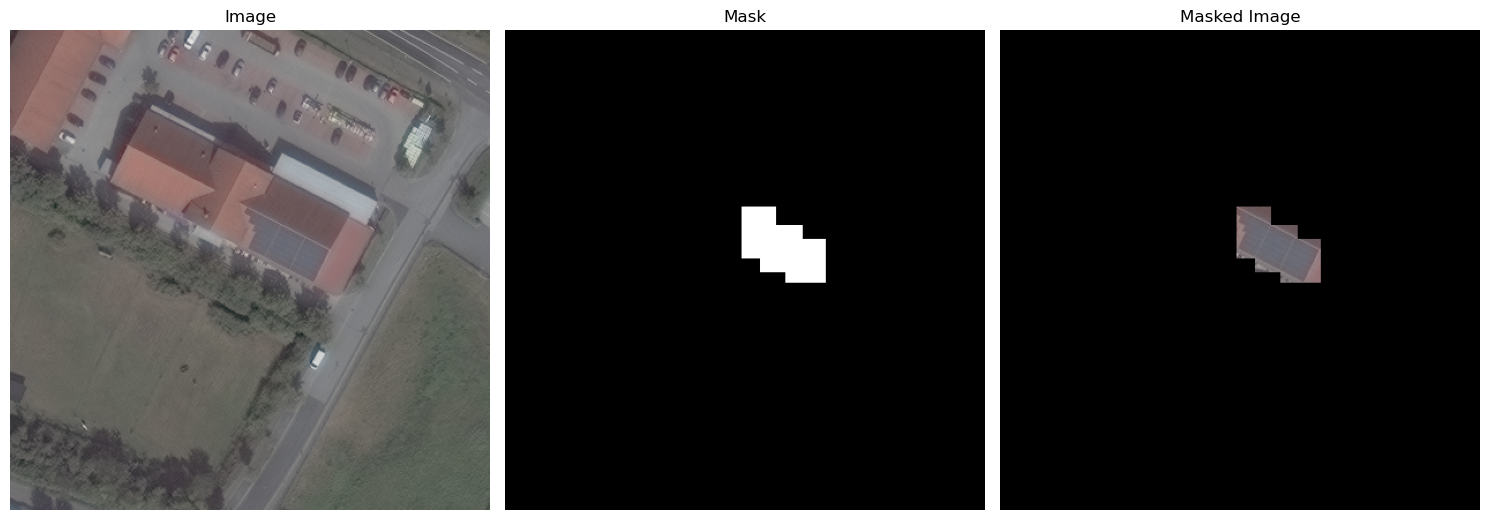

In [16]:
display_image_and_mask(input_chips_dir, output_masks_dir)

# Explore effect of larger/better encoders vs increasing spatial resolution/chip size (higher memory cost!)

## Deep Learning with PyTorch Lightning

PyTorch Lightning is a lightweight PyTorch wrapper that significantly simplifies the process of training deep learning models. It provides a structured framework that abstracts away much of the boilerplate code typically associated with PyTorch training loops, allowing researchers and developers to focus more on the model architecture and data.

**Key Advantages of PyTorch Lightning:**

*   **Reduced Boilerplate:** Lightning handles the engineering aspects of training, such as the training loop, validation loop, and test loop. This means you write less code for common tasks.
*   **Organized Code:** It promotes a clean and organized code structure through its core components: `LightningModule` and `LightningDataModule`.
    *   The `LightningModule` encapsulates all model-related code (architecture, optimizers, training steps, validation steps, etc.).
    *   The `LightningDataModule` handles all data-related operations (data loading, transformations, splitting, batching).
*   **Simplified Training & Iteration:** With the boilerplate handled, iterating on different model architectures or hyperparameters becomes much faster and more straightforward.
*   **Callbacks:** It has a rich ecosystem of callbacks (for checkpointing, early stopping, learning rate monitoring, etc.) that integrate easily into the training process and make managing experiments easier.
    * For example, the `ModelCheckpoint` callback can save the best model based on validation metrics, and the `EarlyStopping` callback can halt training if the model stops improving.
*   **Hardware Agnostic:** Lightning makes it easy to train models on CPUs, GPUs (single or multiple), and TPUs with minimal code changes.
    - You can specify the `accelerator` (e.g., *"gpu"*, **"mps"**, *"tpu"*, "cpu") and `devices` (e.g., number of GPUs) directly as arguments for the `Trainer`
*   **Scalability:** It seamlessly supports distributed training (multi-GPU, multi-node) and mixed-precision training (`precision='16-mixed'`)
    - crucial for training large models like *Geospatial Foundation Models* on large datasets
    <!-- - Lightning [Fabric](https://pytorch-lightning.readthedocs.io/en/stable/extensions/fabric.html) is a new feature that allows for even more flexibility in scaling and distributed training -->
*   **Logging & Monitoring:** Lightning integrates with various logging frameworks (like TensorBoard, **Weights & Biases**, etc.) to track metrics and visualize training progress.
*   **Reproducibility:** By organizing code and managing training details, Lightning helps in creating more reproducible experiments.

As highlighted in the [PyTorch Lightning tutorial by DataCamp](https://www.datacamp.com/tutorial/pytorch-lightning-tutorial), its broad yet useful abstractions allow for quick training and iteration on multiple model architectures and facilitate scaling to multi-GPU or cloud environments. This notebook will leverage these features to efficiently train our PV segmentation models.

In [17]:
img = widgets.Image(value=open("report/assets/figures/xkcd_python.png", "rb").read(), format='png', width='75%', height='auto')
# add html caption
fig_caption = widgets.HTML('<p> What modern Python DL workflows can feel like when things go right. Illustration from xkcd. </p>')
figure = widgets.VBox([img, fig_caption])
# see Box layout manipulation docs: https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20Layout.html#the-flexbox-layout
figure.layout.display = 'flex'
figure.layout.flex_flow = 'column'
figure.layout.align_items = 'center'
figure.layout.width = '100%'
display(figure)

## The Composability of the PyTorch Ecosystem for Data Handling

The PyTorch ecosystem offers a highly composable and flexible set of tools for data loading and preprocessing, which are essential for any deep learning pipeline. Key components include `Dataset`, `DataLoader`, and various transformation libraries.

**Core Components:**

*   **`torch.utils.data.Dataset`:** This is an abstract class representing a dataset. To create a custom dataset, you typically inherit from `Dataset` and override two methods:
    *   `__len__(self)`: Should return the size of the dataset.
    *   `__getitem__(self, idx)`: Should return the sample (e.g., an image and its corresponding mask) at the given index `idx`. This is where you load and preprocess individual data points.

*   **`torch.utils.data.DataLoader`:** This utility wraps an iterable around the `Dataset` to enable easy access to the samples. It handles many crucial aspects of data loading efficiently:
    *   **Batching:** Groups multiple samples into batches.
    *   **Shuffling:** Randomly shuffles the data at every epoch to prevent model bias.
    *   **Parallel Loading:** Uses multiple worker processes (`num_workers`) to load data in parallel, which can significantly speed up training by preventing the GPU from waiting for data.
    *   **Memory Pinning (`pin_memory`):** When using GPUs, setting `pin_memory=True` can speed up data transfer from CPU to GPU memory.

*   **Transformation Libraries (e.g., `torchvision.transforms`, `albumentations`):**
    *   **`torchvision.transforms`:** Provides common image transformations (resizing, cropping, normalization, conversion to tensor, etc.). These are often composed together using `transforms.Compose`.
    *   **`albumentations`:** A powerful library specifically designed for image augmentation. It offers a wide variety of augmentations (flips, rotations, color adjustments, noise, blurs, etc.) and is highly optimized for performance. It integrates well with PyTorch and other frameworks.

**Composability in Action:**

These components are designed to work together seamlessly. A typical workflow involves:
1.  Creating a custom `Dataset` class to load and apply initial transformations to individual image-mask pairs.
2.  Wrapping this `Dataset` instance with a `DataLoader` to manage batching, shuffling, and parallel loading.
3.  The `DataLoader` then provides an iterator that yields batches of data (images and masks) ready to be fed into the model during training or evaluation.

This modular approach, as generally seen in the PyTorch world and highlighted in guides like the [PyTorch Segmentation Models practical guide](https://medium.com/@heyamit10/pytorch-segmentation-models-a-practical-guide-5bf973a32e30), makes the data pipeline flexible, maintainable, and efficient. In this notebook, we use `PVSegmentationDataset` (a custom `Dataset`) and `PVSegmentationDataModule` (which internally uses `DataLoader` and `transforms`) to manage our data.

In [18]:
# Utility file containing Dataset and DataModule classes for PV segmentation
import os
import warnings
from pathlib import Path
import numpy as np
from PIL import Image
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl

# Suppress rasterio warnings for non-georeferenced TIFFs
warnings.filterwarnings("ignore", category=UserWarning, module="rasterio")
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

# prefixed with '_'to avoid overwriting utils import needed for multi-worker batch loading
class _demo_PVSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None,
                 target_size=(832, 832), in_channels=3):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform
        self.target_size = target_size  # Expects a tuple (height, width)
        self.in_channels = in_channels
        if len(self.image_paths) != len(self.mask_paths):
            raise ValueError(f"Mismatch between number of images ({len(self.image_paths)}) and masks ({len(self.mask_paths)})")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_paths[idx], self.mask_paths[idx]
        try:
            if str(img_path).lower().endswith(('.tif', '.tiff')):
                with rasterio.open(img_path) as src:
                    num_bands_to_read = min(self.in_channels, src.count)
                    image_data = src.read(list(range(1, num_bands_to_read + 1)))
                    if image_data.shape[0] < self.in_channels:
                        padding = np.zeros((self.in_channels - image_data.shape[0], src.height, src.width), dtype=image_data.dtype)
                        image_data = np.concatenate((image_data, padding), axis=0)
                    image = np.moveaxis(image_data, 0, -1)  # HWC
                    # Scale to 0-255 if not already, common for satellite imagery
                    if image.max() > 255.0 or image.dtype != np.uint8:
                        if image.max() > 1.0:  # Heuristic for scaling larger integer types
                             image = (image / image.max() * 255).astype(np.uint8)
                        else:  # Assume float 0-1
                             image = (image * 255).astype(np.uint8)
                    # image_pil = Image.fromarray(image)
                    image_pil = image
            else:  # PNG, JPG
                image_pil = Image.open(img_path)
                # Ensure correct number of channels
                if self.in_channels == 3 and image_pil.mode != 'RGB': image_pil = image_pil.convert('RGB')
                elif self.in_channels == 1 and image_pil.mode != 'L': image_pil = image_pil.convert('L')
                elif self.in_channels == 4 and image_pil.mode != 'RGBA': image_pil = image_pil.convert('RGBA')

            if image_pil.size != (self.target_size[1], self.target_size[0]):  # PIL size is (width, height)
                image_pil = image_pil.resize((self.target_size[1], self.target_size[0]), Image.BILINEAR)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}. Using zeros.")
            zero_img_data = np.zeros((self.target_size[0], self.target_size[1], self.in_channels), dtype=np.uint8)
            image_pil = Image.fromarray(zero_img_data)
        try:
            mask_pil = Image.open(mask_path).convert('L')
            if mask_pil.size != (self.target_size[1], self.target_size[0]):
                mask_pil = mask_pil.resize((self.target_size[1], self.target_size[0]), Image.NEAREST)
            mask_np = (np.array(mask_pil) > 127).astype(np.float32)  # Threshold common for masks
            # mask_pil = Image.fromarray(mask_np, mode='F')
            mask_pil = mask_np
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}. Using zeros.")
            mask_pil = Image.fromarray(np.zeros(self.target_size, dtype=np.float32), mode='F')

        # image_tensor = self.transform(image_pil) if self.transform else transforms.ToTensor()(image_pil)
        # mask_tensor = self.mask_transform(mask_pil) if self.mask_transform else transforms.ToTensor()(mask_pil)
        augmented = self.transform(image=image_pil, mask=mask_pil)
        image_tensor = augmented['image']
        mask_tensor = augmented['mask']
        return image_tensor, mask_tensor

datasets/raw/images/maxar_hd_south_germany_PV_OD/image_chips_native/solarpanels_native_3__x0_5164_y0_12946_dxdy_416.tif
Image has 3 bands and shape (3, 416, 416)
Image has data type uint8


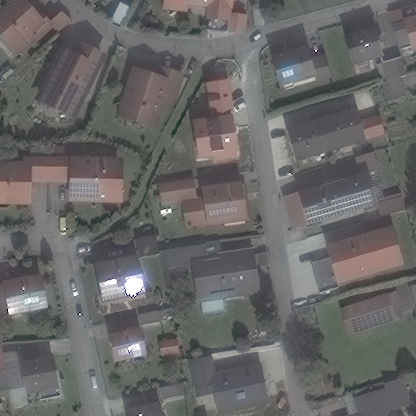

In [19]:
img_dir = IMAGE_PATCH_DIR
img_path = glob(f"{img_dir}/*.tif")[0]
img_path = random.choice(glob(f"{img_dir}/*.tif"))
print(img_path)
with rasterio.open(img_path) as src:
    num_bands_to_read = src.count
    image_data = src.read(list(range(1, num_bands_to_read + 1)))
    print(f"Image has {src.count} bands and shape {image_data.shape}")
    print(f"Image has data type {image_data.dtype}")
    image = np.moveaxis(image_data, 0, -1)  # HWC
    # Scale to 0-255 if not already, common for satellite imagery
    if image.max() > 255.0 or image.dtype != np.uint8:
        if image.max() > 1.0:  # Heuristic for scaling larger integer types
                image = (image / image.max() * 255).astype(np.uint8)
        else:  # Assume float 0-1
                image = (image * 255).astype(np.uint8)
    image_pil = Image.fromarray(image)
    display(image_pil)

In [20]:
# prefixed with '_'to avoid overwriting utils import needed for multi-worker batch loading
class _demo_PVSegmentationDataModule(pl.LightningDataModule):
    def __init__(self, image_dir: str, mask_dir: str, batch_size: int, num_workers: int,
                 val_split_ratio: float, seed: int = 42,
                 patch_size_pixels_dm: int = 256, in_channels_dm: int = 3):
        super().__init__()
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_split_ratio = val_split_ratio
        self.seed = seed
        self.patch_size_tuple = (patch_size_pixels_dm, patch_size_pixels_dm)
        self.in_channels = in_channels_dm

        self.imagenet_mean = [0.485, 0.456, 0.406][:self.in_channels]
        self.imagenet_std = [0.229, 0.224, 0.225][:self.in_channels]
        if self.in_channels == 1:
            self.imagenet_mean, self.imagenet_std = [0.449], [0.226]

        # self.train_transform = Compose([
        #     RandomChoice([
        #         RandomHorizontalFlip(p=0.5),
        #         RandomVerticalFlip(p=0.5),
        #         ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        #         RandomRotation(degrees=180),
        #         RandomResizedCrop(size=(PATCH_SIZE_PIXELS, PATCH_SIZE_PIXELS), scale=(0.8, 1.0)),
        #         RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        #     ]), # Apply one or more of these transforms with 80% probability
        #     ToTensor(), Normalize(mean=self.imagenet_mean, std=self.imagenet_std)])
        self.train_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.SomeOf([ # Apply a random number of these transforms
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                A.Rotate(limit=180),
                A.RandomResizedCrop(height=PATCH_SIZE_PIXELS, width=PATCH_SIZE_PIXELS, scale=(0.8, 1.0)),
                A.Affine(translate_percent=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            ], n=(1,4), p=0.9), # Apply 2 random transforms from the list with 80% prob
            A.Normalize(mean=self.imagenet_mean, std=self.imagenet_std),
            ToTensorV2(),
        ])
        # self.val_transform = transforms.Compose([
        #     transforms.ToTensor(), transforms.Normalize(mean=self.imagenet_mean, std=self.imagenet_std)])
        self.val_transform = A.Compose([
            A.Normalize(mean=self.imagenet_mean, std=self.imagenet_std),
            ToTensorV2(),
        ])
        self.mask_transform = A.Compose([ToTensorV2()])

    def prepare_data(self):
        if not self.image_dir.exists():
            raise FileNotFoundError(f"Image dir not found: {self.image_dir}")
        if not self.mask_dir.exists():
            raise FileNotFoundError(f"Mask dir not found: {self.mask_dir}")
        print(f"Data check: Image dir '{self.image_dir}', Mask dir '{self.mask_dir}' exist.")

    def setup(self, stage: str = None):
        img_exts = ['*.tif', '*.png', '*.jpg', '*.jpeg']
        all_img_paths = []
        # print(f"Searching for images in {self.image_dir}")
        for ext in img_exts:
            all_img_paths.extend(list(self.image_dir.glob(ext)))
        all_img_paths = sorted([p for p in all_img_paths if p.is_file()])

        valid_img_p, all_mask_p, skipped = [], [], 0
        for img_p in all_img_paths:
            found_m = next((self.mask_dir / (img_p.stem + m_ext) for m_ext in ['.png', '.tif', '.jpg', '.jpeg']
                          if (self.mask_dir / (img_p.stem + m_ext)).exists()), None)
            if found_m:
                valid_img_p.append(img_p)
                all_mask_p.append(found_m)
            else:
                skipped += 1

        if skipped > 0:
            print(f"Warning: Skipped {skipped} images due to missing masks during DataModule setup.")
        if not valid_img_p:
            raise ValueError("No valid image/mask pairs found in DataModule setup.")

        ds_size = len(valid_img_p)
        val_s = int(ds_size * self.val_split_ratio)
        train_s = ds_size - val_s

        if train_s <= 0:
            raise ValueError(f"Not enough data for training. Train size: {train_s}")

        indices = list(range(ds_size))
        if val_s > 0:
            train_idx, val_idx = random_split(indices, [train_s, val_s], generator=torch.Generator().manual_seed(self.seed))
        else:
            print("Warning: Validation split resulted in 0 validation samples. Using all data for training. No validation will be performed.")
            train_idx = indices
            val_idx = []

        train_img_list = [valid_img_p[i] for i in train_idx]
        train_mask_list = [all_mask_p[i] for i in train_idx]
        val_img_list = [valid_img_p[i] for i in val_idx]
        val_mask_list = [all_mask_p[i] for i in val_idx]

        self.train_dataset = PVSegmentationDataset(
            train_img_list, train_mask_list,
            self.train_transform, self.mask_transform,
            self.patch_size_tuple, self.in_channels
        )

        self.val_dataset = PVSegmentationDataset(
            val_img_list, val_mask_list,
            self.val_transform, self.mask_transform,
            self.patch_size_tuple, self.in_channels
        ) if val_img_list else None

        print(f"Setup: Train: {len(self.train_dataset)}, Val: {len(self.val_dataset) if self.val_dataset else 'None'}")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,  # Always set pin_memory to True for faster data transfer
            persistent_workers=(self.num_workers > 0)
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=(self.num_workers > 0)
        ) if self.val_dataset else None

    def test_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=(self.num_workers > 0)
        ) if self.val_dataset else None


## `segmentation-models-pytorch` (SMP): A Rich Toolkit for Segmentation

`segmentation-models-pytorch` (SMP) is a Python library built on PyTorch that provides a high-level API for image segmentation tasks. It simplifies the implementation of various state-of-the-art segmentation architectures and allows for easy integration of pre-trained encoders.

**Key Features of SMP:**

*   **Variety of Architectures:** SMP offers a collection of popular and effective segmentation architectures, including:
    *   Unet
    *   Unet++
    *   MAnet
    *   Linknet
    *   FPN (Feature Pyramid Network)
    *   PSPNet (Pyramid Scene Parsing Network)
    *   DeepLabV3 / DeepLabV3+
    *   PAN (Pyramid Attention Network)
    *   DPT (Dense Prediction Transformer)
    *   SegFormer
*   **Pre-trained Encoders:** One of the most powerful features of SMP is its seamless integration with a vast number of pre-trained encoders (backbones). This is largely facilitated by its use of libraries like `timm` (PyTorch Image Models by Ross Wightman).
    *   This allows you to use encoders like ResNets (resnet18, resnet34, resnet50, etc.), EfficientNets (efficientnet-b0 to b7), MobileNets, ViTs (Vision Transformers), and many others, often with weights pre-trained on ImageNet.
    *   Using pre-trained encoders can significantly speed up convergence and improve performance, especially when working with limited datasets.
*   **Ease of Use:** Creating a segmentation model is typically a one-liner: `smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=1)`.
*   **Flexibility:** You can easily switch between different architectures and encoders to experiment and find the best combination for your specific task.
*   **Loss Functions and Metrics:** SMP also includes common loss functions (e.g., DiceLoss, JaccardLoss, FocalLoss) and metrics relevant to segmentation.

As mentioned in the [PyTorch Segmentation Models practical guide](https://medium.com/@heyamit10/pytorch-segmentation-models-a-practical-guide-5bf973a32e30), SMP's strength lies in providing ready-to-use segmentation models with a wide choice of decoders and a huge variety of pre-trained encoders from `timm`. This composability allows for rapid prototyping and benchmarking of different approaches.

In this notebook, we define a `PVSegmentationTask` (a `LightningModule`) that utilizes `smp.create_model` to dynamically build segmentation models based on the configurations specified, allowing us to easily test different architectures and encoders.

In [ ]:
# %% --- 4. PyTorch Lightning Module ---
# PVSegmentationTask class definition (largely the same as previous version)

import wandb
class PVSegmentationTask(pl.LightningModule):
    def __init__(self, model_arch: str, encoder_name: str, encoder_weights: str,
                 in_channels: int, num_classes: int, activation: str,
                 learning_rate: float = 1e-4, loss_weights: tuple = (0.5, 0.5)):
        super().__init__()
        self.save_hyperparameters() # Saves all __init__ args to self.hparams
        # ========== segmentation-models-pytorch block ==========
        self.model = smp.create_model(
            arch=self.hparams.model_arch,
            encoder_name=self.hparams.encoder_name,
            encoder_weights=self.hparams.encoder_weights,
            in_channels=self.hparams.in_channels,
            classes=self.hparams.num_classes,
            activation=self.hparams.activation
        )
        # ========== segmentation-models-pytorch block ==========
        self.dice_loss = DiceLoss(mode='binary', from_logits=(self.hparams.activation is None))
        self.bce_loss = SoftBCEWithLogitsLoss() # Always expects logits
        metrics_args = {"threshold": 0.5}
        metrics_collection = MetricCollection({
            'iou': BinaryJaccardIndex(**metrics_args), 'f1': BinaryF1Score(**metrics_args), 'accuracy': BinaryAccuracy(**metrics_args),
            'precision': BinaryPrecision(**metrics_args), 'recall': BinaryRecall(**metrics_args)})
        self.train_metrics = metrics_collection.clone(prefix='train_')
        self.val_metrics = metrics_collection.clone(prefix='val_')
        self.imagenet_mean = [0.485, 0.456, 0.406][:self.hparams.in_channels]
        self.imagenet_std = [0.229, 0.224, 0.225][:self.hparams.in_channels]

    def forward(self, x):
        return self.model(x)

    def _calculate_loss(self, y_pred, y_true):
        y_true = y_true.float()
        if self.hparams.activation is None: # Model outputs logits
            bce = self.bce_loss(y_pred, y_true)
            dice = self.dice_loss(y_pred, y_true) # DiceLoss will apply sigmoid internally if from_logits=True
        else: # Model outputs probabilities (e.g., after sigmoid)
            eps = 1e-7 # Epsilon to prevent log(0)
            y_pred_c = torch.clamp(y_pred, eps, 1.0 - eps) # Clamp predictions
            logits = torch.log(y_pred_c / (1.0 - y_pred_c + eps) + eps) # Inverse sigmoid, add eps for stability
            bce = self.bce_loss(logits, y_true)
            dice = self.dice_loss(y_pred, y_true) # DiceLoss expects probs here
        return self.hparams.loss_weights[0] * bce + self.hparams.loss_weights[1] * dice

    def _inverse_norm_sample(self, img_arr):

        # apply the inverse transform and get our raw image for validation batch visualization to every img array in the batch
        img_arr = img_arr * np.array(self.imagenet_std) + np.array(self.imagenet_mean)
        return np.clip(img_arr, 0, 1)

    def training_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x)
        loss = self._calculate_loss(y_pred, y_true)
        # Apply sigmoid before updating metrics
        preds = torch.sigmoid(y_pred)
        self.train_metrics.update(preds, y_true.int())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute(), logger=True, prog_bar=False)
        self.train_metrics.reset()

    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        y_pred = self(x) # logits
        loss = self._calculate_loss(y_pred, y_true)
        preds = torch.sigmoid(y_pred)
        self.val_metrics.update(preds, y_true.int())
        # save last batch for saving previews during every k validation ends
        self.last_val_batch = (x, y_true, preds)
        return loss

    def on_validation_epoch_end(self):
        if not self.trainer.sanity_checking: # Skip logging during sanity check
            metrics = self.val_metrics.compute() # Log all val metrics
            self.log_dict(metrics, logger=True, on_step=False, on_epoch=True, prog_bar=False)
            # Log specific metrics for checkpointing and LR scheduler
            # self.log('val_iou', metrics['iou'], on_step=False, on_epoch=True, prog_bar=True, logger=True)
            self.val_metrics.reset()
        # Log sample images, masks, and predictions every 10 epochs
        if (self.trainer.current_epoch) % 10 == 0:

            # Get the last batch from the validation dataloader
            if hasattr(self, 'last_val_batch'):
                images, masks, preds = self.last_val_batch
                # Move to device if necessary
                images = images.to(self.device)
                masks = masks.to(self.device)
                preds = preds.to(self.device)

                # Select a few samples from the batch to visualize
                num_samples_to_log = min(4, images.shape[0]) # Log up to 4 samples
                # Create the main figure and axes outside the loop
                # We need 3 columns (Image, Ground Truth Mask, Predicted Mask) and num_samples_to_log rows
                fig, axes = plt.subplots(num_samples_to_log, 3, figsize=(15, 5 * num_samples_to_log))

                for i in range(num_samples_to_log):
                    img = images[i].cpu().numpy().transpose(1, 2, 0) # Convert to HWC format
                    img = self._inverse_norm_sample(img) # Apply inverse normalization
                    # Ensure data type is uint8 and range is 0-255
                    img = (img * 255).astype(np.uint8)
                    mask = masks[i].cpu().numpy().squeeze() # Remove channel dimension
                    pred = preds[i].cpu().numpy().squeeze() # Remove channel dimension

                    # Create visualizations
                    axes[i, 0].imshow(img)
                    axes[i, 0].set_title("Image")
                    axes[i, 0].axis("off")

                    axes[i, 1].imshow(mask, cmap="gray")
                    axes[i, 1].set_title("Ground Truth Mask")
                    axes[i, 1].axis("off")

                    axes[i, 2].imshow(pred, cmap="gray")
                    axes[i, 2].set_title("Predicted Mask")
                    axes[i, 2].axis("off")

                plt.tight_layout()
                # convert fig to numpy array
                canvas = fig.canvas
                canvas.draw()
                width, height = canvas.get_width_height()
                fig_arr = np.frombuffer(canvas.renderer.buffer_rgba(), dtype='uint8')
                fig_arr = fig_arr.reshape(height, width, 4) # use 4 fixed channels since we're reshaping an RGBA buffer
                # display image during training
                # plt.show()
                plt.close(fig) # Close the figure to prevent memory leaks

                # figs = np.array(fig_imgs)
                # Log to Wandb at end of batch
                wandb_logger = self.logger.experiment
                # our img must be tensor, numpy array or PIL image; not matplotlib fig
                val_fig = wandb.Image(fig_arr, caption="Samples vs Labels vs Predictions")
                # adding captions
                wandb_logger.log({'val_pred_batch': [val_fig]})
                # wandb_logger.log_image(key="val_pred_batch", images=[val_fig], caption=["Sample vs Label vs Prediction"])



    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        # Monitor val_iou for ReduceLROnPlateau since mode is 'max'
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_iou"}}

Data check: Image dir 'datasets/raw/images/maxar_hd_south_germany_PV_OD/image_chips_native', Mask dir 'datasets/raw/labels/maxar_hd_south_germany_PV_OD/masks_native' exist.
Setup: Train: 2034, Val: 508
Visualizing a sample batch from DataModule's train_dataloader...


/Users/alejandovega/miniforge3/envs/eo-pv-cv/lib/python3.12/site-packages/albumentations/core/validation.py:34: UserWarning: Argument 'mask_interpolation' is not valid and will be ignored.
  warn(
/Users/alejandovega/miniforge3/envs/eo-pv-cv/lib/python3.12/site-packages/albumentations/core/validation.py:34: UserWarning: Argument 'rotate_method' is not valid and will be ignored.
  warn(
/Users/alejandovega/miniforge3/envs/eo-pv-cv/lib/python3.12/site-packages/albumentations/augmentations/blur/transforms.py:240: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/Users/alejandovega/miniforge3/envs/eo-pv-cv/lib/python3.12/site-packages/albumentations/core/validation.py:34: UserWarning: Argument 'num_flare_circles_range' is not valid and will be ignored.
  warn(
/Users/alejandovega/miniforge3/envs/eo-pv-cv/lib/python3.12/site-packages/albumentations/core/validation.py:34: UserWarning: Argument 'method' i

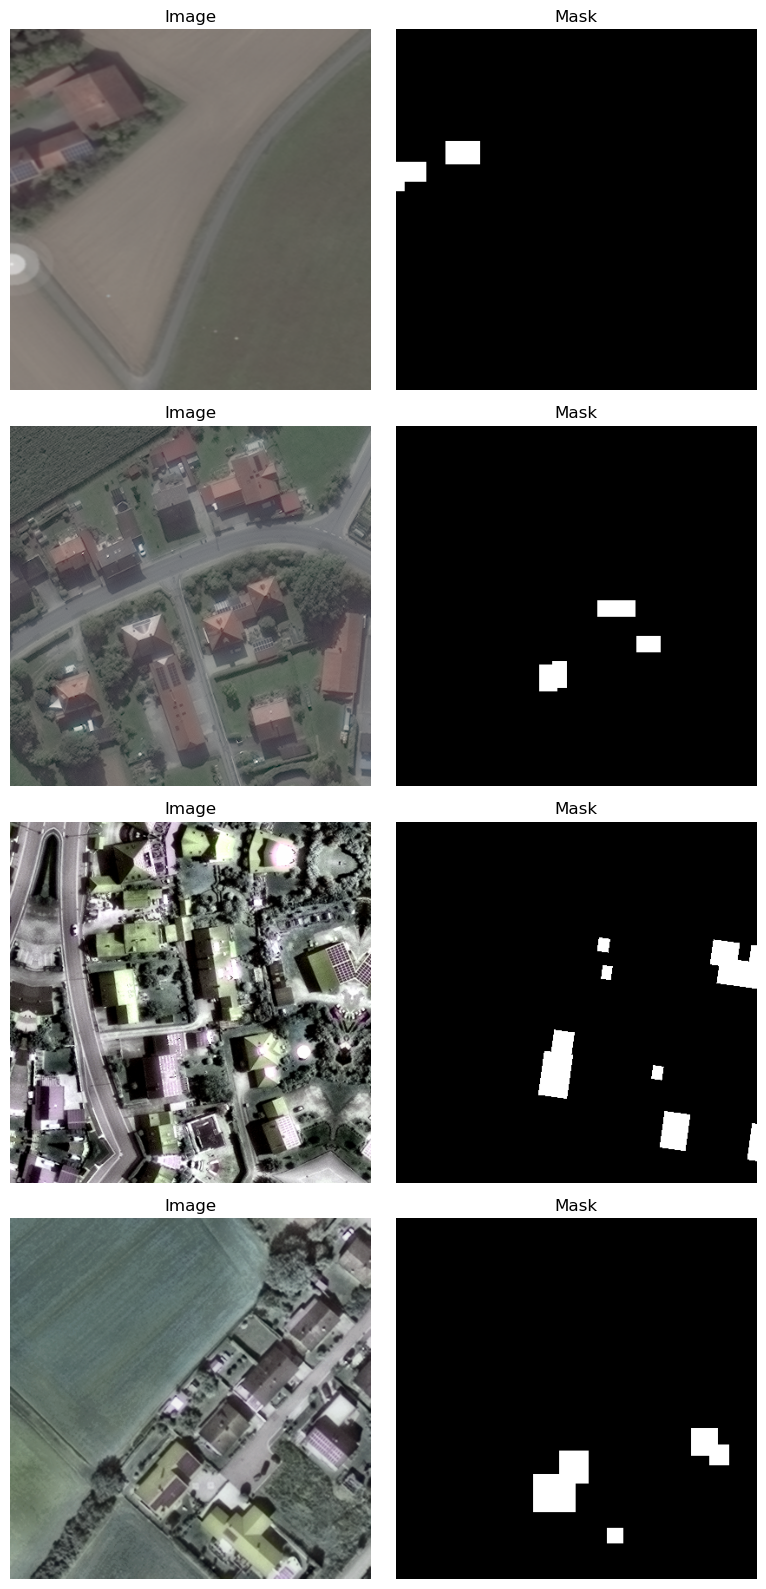

In [22]:
# sanity check for data loader (NOTE: sometimes seeing some cases of images seemingly flipped [on y-axis] )
data_module = PVSegmentationDataModule(
    image_dir=input_chips_dir, mask_dir=output_masks_dir,
    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, # Set to 1 while testing if image matches label during sanity check
    val_split_ratio=VAL_SPLIT_RATIO, patch_size_pixels_dm=PATCH_SIZE_PIXELS, in_channels_dm=IN_CHANNELS
)
try:
    data_module.prepare_data()
    data_module.setup(stage='fit')

    # Visualize a sample batch from DataModule
    train_dl = data_module.train_dataloader()
    if train_dl and len(train_dl) > 0 :
        print("Visualizing a sample batch from DataModule's train_dataloader...")
        images, masks = next(iter(train_dl))
        def show_dm_batch(image_tensor, mask_tensor, num_samples=4, mean_val=None, std_val=None, in_channels=IN_CHANNELS):
            images_np = image_tensor[:num_samples].cpu().numpy()
            masks_np = mask_tensor[:num_samples].cpu().numpy()
            fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 4))
            if num_samples == 1: axes = np.array([axes])
            for i in range(num_samples):
                img = images_np[i].transpose(1, 2, 0)
                if mean_val and std_val:
                    m, s = np.array(mean_val), np.array(std_val)
                    img = s * img + m
                img = np.clip(img, 0, 1)
                if img.shape[-1] == 1: img = img.squeeze(-1) # For grayscale display

                mask = masks_np[i].squeeze()
                axes[i, 0].imshow(img, cmap='gray' if img.ndim==2 else None); axes[i, 0].set_title("Image"); axes[i, 0].axis('off')
                axes[i, 1].imshow(mask, cmap='gray'); axes[i, 1].set_title("Mask"); axes[i, 1].axis('off')
            plt.tight_layout(); plt.show()
        show_dm_batch(images, masks, mean_val=data_module.imagenet_mean, std_val=data_module.imagenet_std)
    else:
        print("Train dataloader from DataModule is empty or not available.")
        data_module = None # Prevent training if data is not loaded

except Exception as e:
    print(f"Error setting up DataModule or visualizing batch: {e}")
    data_module = None



## Streamlined Training with PyTorch Lightning Trainer

Once the `LightningDataModule` (for data handling) and the `LightningModule` (for the model, optimizers, and training/validation logic) are defined, PyTorch Lightning makes the actual training process remarkably straightforward using its `Trainer` class.

**The `Trainer` Class ** (lightning docs excerpt):

The Lightning ``Trainer`` does much more than just "training". *Under the hood*, it handles all loop details for you, some examples include:

- Moving batches and data between correct devices (CPU <-> GPU/TPU).
- Automatically enabling/disabling grads
- Running the training, validation and test dataloaders (iterating over epochs and batches)
- Calling the appropriate methods in your `LightningModule` (e.g., `training_step`, `validation_step`)
- Calling the Callbacks at the appropriate times
    - e.g. Performing optimizer steps and learning rate scheduler adjustments
- Putting batches and computations on the correct devices

Here's the pseudocode for what the trainer does under the hood (showing the train loop only)

```python
    # enable grads
    torch.set_grad_enabled(True)

    losses = []
    for batch in train_dataloader:
        # calls hooks like this one
        on_train_batch_start()
        # train step
        loss = training_step(batch)
        # clear gradients
        optimizer.zero_grad()
        # backward
        loss.backward()
        # update parameters
        optimizer.step()
        losses.append(loss)
```

**Key `Trainer` Arguments Used in this Notebook:**

*   `accelerator`: Specifies the hardware to use (e.g., "mps", "gpu", "cpu").
*   `devices`: Specifies the number of accelerator devices or lists specific device IDs (e.g. gpu0, gpu3)
*   `max_epochs`: maximum number of epochs to train
*   `logger`: Accepts one or more logger instances (e.g., `TensorBoardLogger`, `CSVLogger`) to record metrics and hyperparameters.
*   `callbacks`: A list of callback objects that can customize the training behavior at various points. Common callbacks include:
    *   `ModelCheckpoint`: Saves the model periodically, often based on a monitored metric (e.g., best validation IoU).
    *   `LearningRateMonitor`: Logs the learning rate at each epoch or step.
    *   `EarlyStopping`: Stops training if a monitored metric stops improving for a certain number of epochs (patience).
*   `precision`: Configures training precision (e.g., "32" for full precision, "16-mixed" for mixed-precision training).
    *`compile`: Requires PyTorch 2.0+ and enables JIT compilation for graph optimization, which can speed up training and inference.

**Initiating Training:**

Training is typically started with a single line: `trainer.fit(model, datamodule=data_module)`.

PyTorch Lightning's `Trainer` abstracts away the complexities of the training loop, allowing you to focus on the core components of your deep learning model and experiment more rapidly.

In [23]:
# torch.set_float32_matmul_precision('medium')
# set mps precision 
if data_module.train_dataloader() and (data_module.val_dataloader() or VAL_SPLIT_RATIO == 0):
    for config_name, params in MODEL_CONFIGURATIONS.items():
        print(f"\n--- Training Model: {config_name} ---")
        lightning_model = PVSegmentationTask(
            model_arch=params['arch'], encoder_name=params['encoder'], encoder_weights=ENCODER_WEIGHTS,
            in_channels=IN_CHANNELS, num_classes=NUM_CLASSES, activation=TARGET_ACTIVATION,
            learning_rate=LEARNING_RATE)
        log_version = f"{SELECTED_RESOLUTION_TYPE}_{time.strftime('%Y%m%d-%H%M%S')}"
        # tb_logger = TensorBoardLogger("tb_logs", name=config_name, version=log_version)
        # wandb.ai logger - ensure you have wandb installed (pip install wandb)
        # and WANDB_API_KEY environment variable set.
        # WANDB_PROJECT_NAME should be set in your .env or above.
        wandb_logger = WandbLogger(
            name=f"{config_name}-{log_version}", # Run name in W&B
            project=WANDB_PROJECT_NAME,
            # entity=WANDB_ENTITY, # Optional: your W&B team/entity
            log_model=True # Log model checkpoints to W&B: True, "all", or False
        )
        checkpoint_dir = CHECKPOINT_DIR / config_name / SELECTED_RESOLUTION_TYPE
        checkpoint_cb = pl.callbacks.ModelCheckpoint(
            dirpath=checkpoint_dir,
            filename="{epoch}-{val_iou:.4f}", monitor="val_iou", mode="max", save_top_k=1
        )
        lr_monitor_cb = pl.callbacks.LearningRateMonitor(logging_interval='epoch')
        early_stop_cb = pl.callbacks.EarlyStopping(monitor="val_iou", patience=20, mode="max") # Increased patience

        trainer_kwargs = {"devices": DEVICES, "max_epochs": NUM_EPOCHS,
                          "logger": [wandb_logger], # Use WandbLogger
                          "callbacks": [checkpoint_cb, lr_monitor_cb, early_stop_cb],
                          "log_every_n_steps": 30, "precision": PRECISION_TRAINER}
        print(f"Using these args for Trainer: {trainer_kwargs}")

        trainer = pl.Trainer(accumulate_grad_batches=ACCUM_GRAD_N_BATCHES, **trainer_kwargs)
        # if USE_TORCH_COMPILE:
        #     import torch._dynamo
        #     torch._dynamo.config.suppress_errors = True
        #     compile_mode = USE_TORCH_COMPILE if isinstance(USE_TORCH_COMPILE, str) else True
        #     # lightning_model = torch.compile(lightning_model, fullgraph=True, dynamic=True, backend="cudagraphs")
        #     # look into eager mode
        #     lightning_model = torch.compile(lightning_model, mode=compile_mode, backend="cudagraphs")
        #     print(f"PyTorch 2.0 compilation enabled with mode: {compile_mode}")
        try:
            print(f"Starting training for {config_name} ({SELECTED_RESOLUTION_TYPE}) with {ACCELERATOR}...")
            # torch.set_float32_matmul_precision('medium')
            trainer.fit(lightning_model, datamodule=data_module)
            print(f"Training finished for {config_name} ({SELECTED_RESOLUTION_TYPE}).")
            if checkpoint_cb.best_model_path: print(f"Best model saved at: {checkpoint_cb.best_model_path}")
            wandb_logger.experiment.finish() # Finish W&B run
            print(f"Wandb run finished for {config_name} ({SELECTED_RESOLUTION_TYPE}).")
            # Optionally, save the model checkpoint to a specific directory
        except Exception as e:
            print(f"Error training {config_name}: {e}")
            traceback.print_exc()
            if wandb_logger.experiment: wandb_logger.experiment.finish(exit_code=1) # Finish run with error
            continue
else:
    print("DataLoaders not available. Skipping training. Check DataModule setup and data paths.")


--- Training Model: UnetPlusPlus_resnet50 ---


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Using these args for Trainer: {'devices': 1, 'max_epochs': 25, 'logger': [<pytorch_lightning.loggers.wandb.WandbLogger object at 0x36384a300>], 'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x36fb50500>, <pytorch_lightning.callbacks.lr_monitor.LearningRateMonitor object at 0x36fbcab40>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x363c2f1a0>], 'log_every_n_steps': 30, 'precision': '32'}
Starting training for UnetPlusPlus_resnet50 (native) with mps...
Data check: Image dir 'datasets/raw/images/maxar_hd_south_germany_PV_OD/image_chips_native', Mask dir 'datasets/raw/labels/maxar_hd_south_germany_PV_OD/masks_native' exist.


wandb: Currently logged in as: avega to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Setup: Train: 2034, Val: 508



  | Name          | Type                  | Params | Mode 
----------------------------------------------------------------
0 | model         | UnetPlusPlus          | 49.0 M | train
1 | dice_loss     | DiceLoss              | 0      | train
2 | bce_loss      | SoftBCEWithLogitsLoss | 0      | train
3 | train_metrics | MetricCollection      | 0      | train
4 | val_metrics   | MetricCollection      | 0      | train
----------------------------------------------------------------
49.0 M    Trainable params
0         Non-trainable params
49.0 M    Total params
195.943   Total estimated model params size (MB)
315       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
NUM_EPOCHS

25

In [ ]:
# # setup local tensorboard logging
%load_ext tensorboard
# Remember to move the logs to gdrive so we save our experiments logs
%tensorboard --logdir tb_logs --port 6006
PRECISION_TRAINER = '16-mixed'

In [ ]:
torch._dynamo.list_backends()

['cudagraphs', 'inductor', 'onnxrt', 'openxla', 'tvm']

## Model Evaluation and Prediction Visualization

After training, it's crucial to evaluate the model's performance on unseen data (typically the validation or a separate test set) and visualize its predictions to gain qualitative insights. This section demonstrates a basic approach to:

1.  **Loading the Best Model:** PyTorch Lightning's `ModelCheckpoint` callback saves the best performing model based on a monitored metric. We load this checkpoint for evaluation.
2.  **Making Predictions:** The loaded model is used to make predictions on a batch of data from the validation set.
3.  **Visualizing Results:** The original images, ground truth masks, and the model's predicted masks are displayed side-by-side for comparison.

This allows for a visual assessment of how well the model is segmenting the PV panels.

In [ ]:
# --- 6. Evaluation & Visualization (Example) ---

if data_module and MODEL_CONFIGURATIONS:
        print("test")
        first_config_name = list(MODEL_CONFIGURATIONS.keys())[0]
        # Determine device for evaluation (mps, cuda, or cpu)
        if torch.backends.mps.is_available() and torch.backends.mps.is_built():
            DEVICE_EVAL = torch.device("mps")
        elif torch.cuda.is_available():
            DEVICE_EVAL = torch.device("cuda")
        else:
            DEVICE_EVAL = torch.device("cpu")
        print(f"Using device for evaluation: {DEVICE_EVAL}")

        eval_resolution_type = SELECTED_RESOLUTION_TYPE
        if checkpoint_dir.exists():
            ckpt_files = sorted(list(checkpoint_dir.glob("*.ckpt")), key=os.path.getmtime, reverse=True)
            if ckpt_files:
                best_model_path_eval = ckpt_files[0] # Load the most recently saved best model
                print(f"\n--- Evaluating and Visualizing: {first_config_name} from {best_model_path_eval} ---")
                try:
                    eval_model = PVSegmentationTask.load_from_checkpoint(best_model_path_eval, map_location=DEVICE_EVAL)
                    eval_model.to(DEVICE_EVAL) # Ensure model is on the correct device
                    eval_model.eval()

                    # current_eval_patch_size = 416 if eval_resolution_type == 'native' else 832
                    current_eval_patch_size = PATCH_SIZE_PIXELS
                    # Check if DataModule needs re-setup for the evaluation resolution/patch size
                    dm_params_match = (hasattr(data_module, 'patch_size_tuple') and
                                    data_module.patch_size_tuple == (current_eval_patch_size, current_eval_patch_size) and
                                    Path(data_module.image_dir).name == f"image_chips_{eval_resolution_type}")

                    if not dm_params_match:
                        print(f"Re-setting up DataModule for evaluation: resolution {eval_resolution_type}, patch size {current_eval_patch_size}")
                        # Determine correct IMAGE_PARENT_DIR and MASK_PARENT_DIR for eval if they changed
                        eval_image_dir = str(IMAGE_PATCH_DIR)
                        eval_mask_dir = str(MASK_DIR)

                        data_module_eval = PVSegmentationDataModule(
                            image_dir=str(eval_image_dir), mask_dir=str(eval_mask_dir),
                            batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                            val_split_ratio=VAL_SPLIT_RATIO, # or 0.99 for nearly all data if just for viz
                            patch_size_pixels_dm=current_eval_patch_size,
                            in_channels_dm=IN_CHANNELS
                        )
                        data_module_eval.prepare_data()
                        data_module_eval.setup(stage='test') # or 'test' if you have a test_dataloader
                        val_loader_eval = data_module_eval.val_dataloader()
                        dm_for_viz = data_module_eval
                    else:
                        val_loader_eval = data_module.val_dataloader()
                        dm_for_viz = data_module

                    if val_loader_eval and len(val_loader_eval) > 0:
                        images_eval, masks_gt_eval = next(iter(val_loader_eval))
                        images_eval = images_eval.to(DEVICE_EVAL) # Move images to device

                        with torch.no_grad():
                            masks_pred_eval = eval_model(images_eval).cpu() # Move predictions to CPU for numpy/PIL

                        unnorm_transform = transforms.Compose([
                            transforms.Normalize(mean=[0.]*IN_CHANNELS, std=[1/s for s in data_module.imagenet_std]),
                            transforms.Normalize(mean=[-m for m in data_module.imagenet_mean], std=[1.]*IN_CHANNELS),
                            transforms.ToPILImage()
                        ])
                        masks_gt_pil = [transforms.ToPILImage()(m.cpu()) for m in masks_gt_eval]
                        if eval_model.hparams.activation is None: masks_pred_eval = torch.sigmoid(masks_pred_eval)
                        masks_pred_binary_pil = [transforms.ToPILImage()((m > 0.5).float().cpu()) for m in masks_pred_eval]

                        num_to_show = min(4, images_eval.size(0))
                        fig, axes = plt.subplots(num_to_show, 3, figsize=(12, num_to_show * 4))
                        if num_to_show == 1: axes = np.array([axes]) # Ensure axes is always 2D for consistent indexing
                        for i in range(num_to_show):
                            img_pil = unnorm_transform(images_eval[i].cpu()) # Move image to CPU before unnorm
                            axes[i, 0].imshow(img_pil); axes[i, 0].set_title("Image"); axes[i, 0].axis('off')
                            axes[i, 1].imshow(masks_gt_pil[i], cmap='gray'); axes[i, 1].set_title("Ground Truth"); axes[i, 1].axis('off')
                            axes[i, 2].imshow(masks_pred_binary_pil[i], cmap='gray'); axes[i, 2].set_title("Prediction"); axes[i, 2].axis('off')
                        plt.tight_layout(); plt.show()
                    else: print("Validation dataloader not available or empty for visualization.")
                except Exception as e: print(f"Error during eval/viz of {first_config_name}: {e}"); import traceback; traceback.print_exc()
            else: print(f"No checkpoint file found in {checkpoint_dir} for {first_config_name}.")
        else: print(f"Checkpoint directory not found for {first_config_name}. Train first.")

test
Using device for evaluation: mps
Checkpoint directory not found for UnetPlusPlus_resnet50. Train first.


## Next Steps: Model Training

Review the logs generated in wandb and the `tb_logs/` (TensorBoard) directory, and inspect the saved model checkpoints to monitor training progress and select the best models.

Here are some potential next steps and areas for further experimentation of these segmentation models:

* **Organize benchmark runs results**: To make our observations on which model architecture and encoder combinations perform best  
* **Full Training Runs:** Increase `NUM_EPOCHS` for more comprehensive training.
*   **Hyperparameter Tuning:** Experiment with different learning rates, batch sizes, optimizer settings, and loss function weights.
*   **Explore More Architectures/Encoders:** Leverage the flexibility of `segmentation-models-pytorch` to try other model configurations available in `MODEL_CONFIGURATIONS` or add new ones.
*   **Data Augmentation:** Implement more sophisticated data augmentation techniques using `albumentations` within the `PVSegmentationDataset` or `PVSegmentationDataModule` to improve model generalization.
*   **Advanced Loss Functions:** Explore other loss functions or combinations suitable for imbalanced segmentation tasks.
*   **Test Set Evaluation:** Create a dedicated test set (if not already done) and evaluate the final model on it for an unbiased performance measure.
*   **Post-processing:** Implement post-processing steps (e.g., removing small predicted regions, morphological operations) to potentially improve segmentation quality.
*   **Larger Datasets:** Train on my larger and more diverse collated dataset
*   **Cross-Validation:** Implement k-fold cross-validation for more robust performance estimation.



In [ ]:
# %% --- 7. Next Steps ---
print("\nNotebook execution finished.")
print("Next steps: Review logs in 'tb_logs/' and 'csv_logs/'. Check 'checkpoints/' for saved models.")
print("Consider increasing NUM_EPOCHS for full training runs.")


Notebook execution finished.
Next steps: Review logs in 'tb_logs/' and 'csv_logs/'. Check 'checkpoints/' for saved models.
Consider increasing NUM_EPOCHS for full training runs.


In [ ]:
# %% --- 8. Export to CoreML and Quantization ---

# Only run this cell after successful training and evaluation

if 'eval_model' not in locals() or eval_model is None:
    print("No model available for export. Please run the evaluation cell first.")
else:
    print("Preparing model for export to CoreML...")

    try:
        import coremltools as ct
        from coremltools.models.neural_network import quantization_utils

        # Move model to CPU for export
        lightning_model.to('cpu')
        lightning_model.eval()

        # Define input shape
        example_input = torch.rand(1, IN_CHANNELS, PATCH_SIZE_PIXELS, PATCH_SIZE_PIXELS)

        # First, export to TorchScript format
        scripted_model = torch.jit.trace(lightning_model, example_input)

        # Convert to CoreML
        print("Converting model to CoreML format...")
        mlmodel = ct.convert(
            scripted_model,
            inputs=[ct.TensorType(name="input", shape=example_input.shape)],
            convert_to="mlprogram",  # Use the newer ML Program format for better performance
            # compute_units="ALL"  # Can be "ALL", "CPU_ONLY", "CPU_AND_GPU", "CPU_AND_NE" (Neural Engine)
        )

        # Set model metadata
        mlmodel.short_description = "PV Segmentation using PyTorch Lightning and SMP"
        mlmodel.input_description['input'] = "Input image (RGB or multi-channel)"
        output_name = mlmodel._spec.description.output[0].name
        mlmodel.output_description[output_name] = "Segmentation mask for PV panels"

        # Save the model
        output_path = Path("exported_models") / f"{first_config_name}_coreml.mlpackage"
        os.makedirs(output_path.parent, exist_ok=True)
        mlmodel.save(str(output_path))
        print(f"Model successfully exported to: {output_path}")

        # ---------- QUANTIZATION OPTIONS (COMMENTED) ----------

        # # FP16 Quantization
        # print("\nCreating FP16 quantized model...")
        # mlmodel_fp16 = quantization_utils.quantize_weights(mlmodel, nbits=16)
        # mlmodel_fp16.save(str(output_path).replace(".mlpackage", "_fp16.mlpackage"))
        # print("FP16 model saved.")

        # # INT8 Quantization (more aggressive compression, may affect accuracy)
        # # print("\nCreating INT8 quantized model...")
        # # mlmodel_int8 = quantization_utils.quantize_weights(mlmodel, nbits=8)
        # # mlmodel_int8.save(str(output_path).replace(".mlpackage", "_int8.mlpackage"))
        # # print("INT8 model saved.")

        # # For even more advanced quantization with calibration:
        # # from coremltools.optimize.coreml import create_quantized_model
        # # mlmodel_quantized = create_quantized_model(
        # #    mlmodel,
        # #    calibration_data=create_image_generator(calibration_images),
        # #    multiarray_dtype='int8'
        # # )

    except ImportError as e:
        print(f"CoreML export failed: {e}")
        print("Please install coremltools using: pip install coremltools")
    except Exception as e:
        print(f"Error during CoreML export: {e}")
        import traceback
        traceback.print_exc()


No model available for export. Please run the evaluation cell first.


## Next steps [Thesis Work]

- start training over our 300K+ coordinates of PV locations
    - only ~120K labels are Polygons instead of points
- Explore use of YOLO → SAM2 pipeline to get more precise labels
- Build data pipelines to fetch imagery from STAC catalogs
- explore use of Template matching, Feature Descriptors, and other pre-DL CV techniques
- Incorporate the use of Spectral Indices *specific to Photovoltaic materials* (Preview below!)

## Open, Published PV Solar Panel Locations

- Aggregated multiple open, published datasets of PV locations worldwide.
- Sources include Zenodo, Figshare, GitHub, ScienceBase.
- Variety of formats (CSV, *GeoJSON* [ideal], Shapefile, etc.).
- Goal: Create a consolidated, deduplicated dataset for analysis.

Here we list the dataset titles of publications alongside their first author, DOI links, and their number of labels:
- **"Distributed solar photovoltaic array location and extent dataset for remote sensing object identification"** - K. Bradbury, 2016 | [paper DOI](https://doi.org/10.1038/sdata.2016.106) | [dataset DOI](https://doi.org/10.6084/m9.figshare.3385780.v4) | polygon annotations for 19,433 PV modules in 4 cities in California, USA
- "A solar panel dataset of very high resolution satellite imagery to support the Sustainable Development Goals" - C. Clark et al, 2023 | [paper DOI](https://doi.org/10.1038/s41597-023-02539-8) | [dataset DOI](https://doi.org/10.6084/m9.figshare.22081091.v3) | 2,542 object labels (per spatial resolution)
- **"A harmonised, high-coverage, open dataset of solar photovoltaic installations in the UK" - D. Stowell et al, 2020** | [paper DOI](https://doi.org/10.1038/s41597-020-00739-0) | [dataset DOI](https://zenodo.org/records/4059881) | 265,418 data points (over 255,000 are stand-alone installations, 1067 solar farms, and rest are subcomponents within solar farms)
- "Georectified polygon database of ground-mounted large-scale solar photovoltaic sites in the United States" - K. Sydny, 2023 | [paper DOI](https://doi.org/10.1038/s41597-023-02644-8) | [dataset DOI](https://www.sciencebase.gov/catalog/item/6671c479d34e84915adb7536) | 4186 data points
- "Vectorized solar photovoltaic installation dataset across China in 2015 and 2020" - J. Liu et al, 2024 | [paper DOI](https://doi.org/10.1038/s41597-024-04356-z) | [dataset link](https://github.com/qingfengxitu/ChinaPV) | 3,356 PV labels (inspect quality!)
- "Multi-resolution dataset for photovoltaic panel segmentation from satellite and aerial imagery" - H. Jiang, 2021 | [paper DOI](https://doi.org/10.5194/essd-13-5389-2021) | [dataset DOI](https://doi.org/10.5281/zenodo.5171712) | 3,716 samples of PV data points
- "A crowdsourced dataset of aerial images with annotated solar photovoltaic arrays and installation metadata" - G. Kasmi, 2023 | [paper DOI](https://doi.org/10.1038/s41597-023-01951-4) | [dataset DOI](https://doi.org/10.5281/zenodo.6865878) | > 28K points of PV installations; 13K+ segmentation masks for PV arrays; metadata for 8K+ installations
- **"An Artificial Intelligence Dataset for Solar Energy Locations in India"** - A. Ortiz, 2022 | [paper DOI](https://doi.org/10.1038/s41597-022-01499-9) | [dataset link 1](https://researchlabwuopendata.blob.core.windows.net/solar-farms/solar_farms_india_2021.geojson) or [dataset link 2](https://raw.githubusercontent.com/microsoft/solar-farms-mapping/refs/heads/main/data/solar_farms_india_2021_merged_simplified.geojson) | 117 geo-referenced points of solar installations across India
- "GloSoFarID: Global multispectral dataset for Solar Farm IDentification in satellite imagery" - Z. Yang, 2024** | [paper DOI](https://doi.org/10.48550/arXiv.2404.05180) | [dataset DOI](https://github.com/yzyly1992/GloSoFarID/tree/main/data_coordinates) | 6,793 PV samples across 3 years (double counting of samples)
- **"A global inventory of photovoltaic solar energy generating units" - L. Kruitwagen et al, 2021** | [paper DOI](https://doi.org/10.1038/s41586-021-03957-7) | [dataset DOI](https://doi.org/10.5281/zenodo.5005867) | 50,426 for training, cross-validation, and testing; 68,661 predicted polygon labels
- **"Harmonised global datasets of wind and solar farm locations and power" - S. Dunnett et al, 2020** | [paper DOI](https://doi.org/10.1038/s41597-020-0469-8) | [dataset DOI](https://doi.org/10.6084/m9.figshare.11310269.v6) | 35272 PV installations

In [ ]:
%%time
load_dotenv()
DATASET_DIR = Path(os.getenv('DATA_PATH'))
ZSTD_COMPRESSION = os.getenv("GPQ_ZSTD_COMPRESSION", 5)
TABLE_NAME = os.getenv("PV_DB_TABLE", "global_consolidated_pv")

dataset_choices = [
    'global_harmonized_large_solar_farms_2020', 'global_pv_inventory_sent2_spot_2021', 'ind_pv_solar_farms_2022', 'usa_cali_usgs_pv_2016', 'uk_crowdsourced_pv_2020'
]

# get list of geoparquet files to be consolidated
get_full_gpq_path = lambda f: DATASET_DIR / 'raw' / 'labels' / 'geoparquet' / f
parquet_files = [get_full_gpq_path(f) for f in os.listdir(DATASET_DIR / 'raw' / 'labels' / 'geoparquet') if any(os.path.splitext(f)[0].startswith(ds) for ds in selected_datasets)]
flist = '\n-'.join([os.path.relpath(f) for f in parquet_files])
print(f"Consolidating these {len(parquet_files)} files:\n-{flist}")

DB_DIR = Path(os.getenv("DUCKDB_DIR", DATASET_DIR / 'db'))
out_consolidated_parquet = DATASET_DIR / 'prepared' / 'labels' / 'geoparquet' / 'global_consolidated_pv.geoparquet'
out_consolidated_db = DB_DIR / 'global_consolidated_pv.duckdb'
# create the output directories if they don't exist
print(f"Creating output directories: {out_consolidated_parquet.parent}")
os.makedirs(out_consolidated_parquet.parent, exist_ok=True)

# consolidate the dataset into a single duckdb database that will also be saved as a geoparquet file
# exclude POINT and MULTIPOINT geometries until we have implemented a heuristic to extract a PV polygon label from the points
# TODO: look at usability of SAM2 models that perform segmentation from single point input
db_file = geom_db_consolidate_dataset(
    parquet_files=parquet_files,
    table_name=TABLE_NAME,
    geom_column="geometry",
    keep_geoms=["POLYGON", "MULTIPOLYGON", "POINT", "MULTIPOINT"],
    spatial_index=True,
    out_parquet=out_consolidated_parquet,
    printout=True
)

NameError: name 'selected_datasets' is not defined

In [ ]:
%load_ext sql
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
conn = get_duckdb_connection(db_file)
%sql conn --alias duckdb

NameError: name 'get_duckdb_connection' is not defined

In [ ]:
# display db tables
%sql SHOW TABLES;

In [ ]:
%sql DESCRIBE {{TABLE_NAME}};

In [ ]:
%sql SUMMARIZE SELECT unified_id, area_m2, centroid_lon, centroid_lat, dataset, bbox FROM {{TABLE_NAME}}

In [ ]:
# source gdf for visualization directly from db in cases where ds_gdf is deleted further below
fetch_query = f"""
SELECT unified_id, dataset, area_m2, centroid_lon, centroid_lat, bbox, ST_AsText(geometry) AS geometry
FROM {TABLE_NAME}; """
%time pv_gdf = conn.sql(fetch_query).df()

# convert the geometry column from WKT to shapely geometries
pv_gdf = gpd.GeoDataFrame(pv_gdf, geometry=pv_gdf['geometry'].apply(wkt.loads), crs="EPSG:4326")
# only keep the rows that have area_m2 > 0
pv_gdf = pv_gdf[pv_gdf['area_m2'] > 0]
# # sample 100K rows for visualization
# pv_gdf = pv`x_gdf.sample(50000, random_state=42)

In [ ]:
# %% --- 1.8 Spectral Index Demo with Sentinel-2 & Cubo ---

# --- Configuration for SPPI Demo ---
N_SAMPLES_TO_VISUALIZE_DEMO = 2  # Number of large PV sites to pick for the demo
S2_CHIP_SIZE_DEMO = 256         # Pixel size of the S2 chip to fetch (e.g., 256x256 for a 2560x2560m area)
S2_RESOLUTION_DEMO = 10         # Target resolution for S2 imagery (meters)
STAC_API_URL_DEMO = "https://planetarycomputer.microsoft.com/api/stac/v1"
S2_COLLECTION_DEMO = "sentinel-2-l2a" # Sentinel-2 L2A (Surface Reflectance)

# Define a few time windows for the demo (e.g., different seasons)
# Format: (datetime_string_for_cubo, display_label)
# Example: Fetch imagery around specific dates of interest if known, or seasonal.
# For this demo, let's pick a few distinct periods.
TIME_WINDOWS_DEMO = [
    ("2022-03-01/2022-03-31", "Mar 2022 (Spring)"),
    ("2022-06-01/2022-06-30", "Jun 2022 (Summer)"),
    ("2022-09-01/2022-09-30", "Sep 2022 (Fall)"),
]

# Bands needed for all indices and RGB:
# SPPI: B01 (Coastal), B03 (Green), B08 (NIR), B11 (SWIR1)
# NDVI: B04 (Red), B08 (NIR)
# NDPI (He et al. variant): B08 (NIR), B11 (SWIR1)
# SPI (Tian et al. variant from He et al.): B03 (Green), B04 (Red), B08 (NIR), B11 (SWIR1), B12 (SWIR2)
# RGB: B04 (Red), B03 (Green), B02 (Blue)
ALL_REQUIRED_S2_BANDS_DEMO = sorted(list(set(["B01", "B02", "B03", "B04", "B08", "B11", "B12"])))

In [ ]:
# # %% --- 9. Interactive Visualization Slideshow ---

# from IPython.display import HTML, Image, display
# import os
# from pathlib import Path
# import ipywidgets as widgets
# import matplotlib.pyplot as plt
# import glob

# def create_slideshow(image_dir="report/assets/visualizations", height=500):
#     """Create an interactive slideshow from images in the specified directory.

#     Args:
#         image_dir: Path to directory containing the screenshots/images
#         height: Height in pixels for the display area

#     Returns:
#         Interactive widget displaying the slideshow
#     """
#     # Create directory if it doesn't exist
#     os.makedirs(image_dir, exist_ok=True)

#     # Find all image files
#     image_extensions = ["jpg", "jpeg", "png", "gif"]
#     image_files = []
#     for ext in image_extensions:
#         image_files.extend(glob.glob(os.path.join(image_dir, f"*.{ext}")))
#         image_files.extend(glob.glob(os.path.join(image_dir, f"*.{ext.upper()}")))  # Include uppercase extensions

#     image_files = sorted(image_files)  # Sort alphabetically

#     if not image_files:
#         print(f"No images found in {image_dir}")
#         print(f"Please add your screenshots to the {image_dir} directory")
#         print(f"Supported formats: {', '.join(image_extensions)}")
#         return None

#     # Create widgets
#     slider = widgets.IntSlider(
#         value=0,
#         min=0,
#         max=len(image_files)-1,
#         step=1,
#         description='Image:',
#         continuous_update=False,
#         layout=widgets.Layout(width='50%')
#     )

#     prev_button = widgets.Button(
#         description='Previous',
#         disabled=False,
#         button_style='',
#         tooltip='Previous image',
#         icon='arrow-left'
#     )

#     next_button = widgets.Button(
#         description='Next',
#         disabled=False,
#         button_style='',
#         tooltip='Next image',
#         icon='arrow-right'
#     )

#     image_widget = widgets.Image(
#         layout=widgets.Layout(height=f"{height}px"),
#     )

#     title_widget = widgets.HTML(
#         layout=widgets.Layout(height='auto')
#     )

#     # Define callback functions
#     def on_slider_change(change):
#         index = change['new']
#         display_image(index)

#     def on_prev_button_click(b):
#         if slider.value > 0:
#             slider.value -= 1

#     def on_next_button_click(b):
#         if slider.value < len(image_files) - 1:
#             slider.value += 1

#     def display_image(index):
#         filename = image_files[index]
#         with open(filename, 'rb') as f:
#             image_widget.value = f.read()

#         base_filename = os.path.basename(filename)
#         title_widget.value = f"<div style='text-align: center; font-weight: bold;'>{base_filename} ({index + 1}/{len(image_files)})</div>"

#     # Attach callbacks to widgets
#     slider.observe(on_slider_change, names='value')
#     prev_button.on_click(on_prev_button_click)
#     next_button.on_click(on_next_button_click)

#     # Display initial image
#     display_image(0)

#     # Arrange widgets
#     button_box = widgets.HBox([prev_button, next_button])
#     main_box = widgets.VBox([title_widget, image_widget, slider, button_box])

#     return main_box

# # Create and display the slideshow widget
# slideshow = create_slideshow()

# if slideshow:
#     display(slideshow)
# else:
#     # Create directory structure if it doesn't exist
#     viz_dir = "report/assets/visualizations"
#     os.makedirs(viz_dir, exist_ok=True)

#     # Display placeholder image with instructions
#     plt.figure(figsize=(10, 6))
#     plt.text(0.5, 0.5, f"Add your screenshots to:\n{os.path.abspath(viz_dir)}",
#              ha='center', va='center', fontsize=16, wrap=True)
#     plt.axis('off')
#     plt.title("Interactive Slideshow - Setup Instructions", fontsize=18)
#     plt.tight_layout()
#     plt.show()

#     print("\nTo use the slideshow:")
#     print(f"1. Add your screenshot images to: {os.path.abspath(viz_dir)}")
#     print("2. Make sure they're in jpg, jpeg, png, or gif format")
#     print("3. Re-run this cell to see the interactive slideshow")
#     print("\nTip: You can change the images directory by modifying the argument to create_slideshow()")